## Шаг 0: Зависимости

In [397]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, fbeta_score, mean_squared_error, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from statsmodels.tsa.arima.model import ARIMA 
from tqdm import tqdm
import copy

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Шаг 1: Загрузка данных

In [398]:
# # Загрузка всех таблиц
# telemetry = pd.read_csv(r"C:\Users\valekseeva\Documents\Project\Hybrid-Predictive-Maintenance\Datasets\PdM_telemetry.csv")
# errors = pd.read_csv(r"C:\Users\valekseeva\Documents\Project\Hybrid-Predictive-Maintenance\Datasets\PdM_errors.csv")
# maint = pd.read_csv(r"C:\Users\valekseeva\Documents\Project\Hybrid-Predictive-Maintenance\Datasets\PdM_maint.csv")
# failures = pd.read_csv(r"C:\Users\valekseeva\Documents\Project\Hybrid-Predictive-Maintenance\Datasets\PdM_failures.csv")
# machines = pd.read_csv(r"C:\Users\valekseeva\Documents\Project\Hybrid-Predictive-Maintenance\Datasets\PdM_machines.csv")

In [399]:
# Загрузка всех таблиц
telemetry = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_telemetry.csv")
errors = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_errors.csv")
maint = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_maint.csv")
failures = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_failures.csv")
machines = pd.read_csv("/Users/admin/Documents/GitHub/Hybrid-Predictive-Maintenance/Datasets/PdM_machines.csv")

In [400]:
# Преобразование даты
for df in [telemetry, errors, maint, failures]:
    df["datetime"] = pd.to_datetime(df["datetime"])

In [401]:
telemetry.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [402]:
errors.head()

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


errorID
error1    1010
error2     988
error3     838
error4     727
error5     356
Name: count, dtype: int64

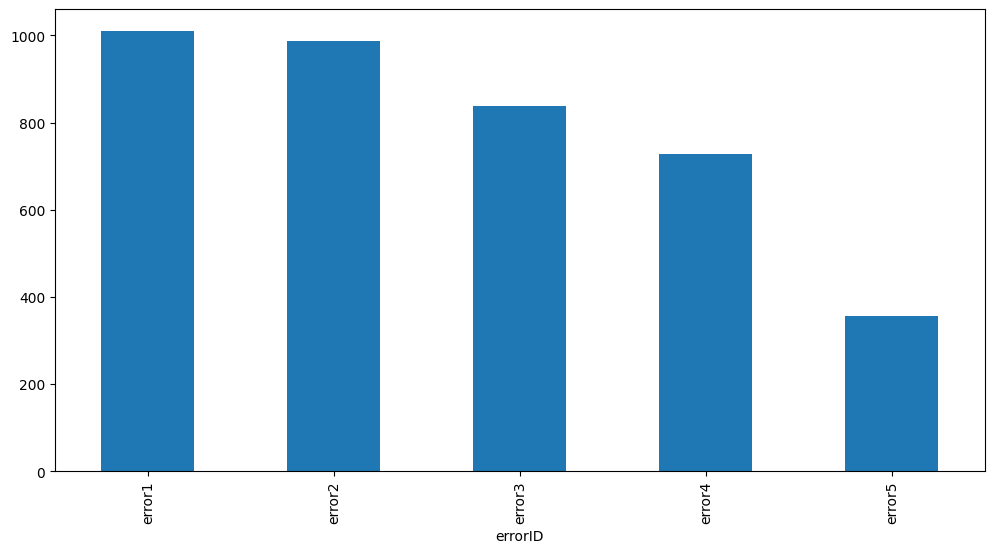

In [403]:
plt.figure(figsize=(12, 6))
errors["errorID"].value_counts().plot(kind="bar")
errors["errorID"].value_counts()

In [404]:
maint.head()

,datetime,machineID,comp
0,2014-06-01 06:00:00,1,comp2
1,2014-07-16 06:00:00,1,comp4
2,2014-07-31 06:00:00,1,comp3
3,2014-12-13 06:00:00,1,comp1
4,2015-01-05 06:00:00,1,comp4


comp
comp2    863
comp4    811
comp3    808
comp1    804
Name: count, dtype: int64

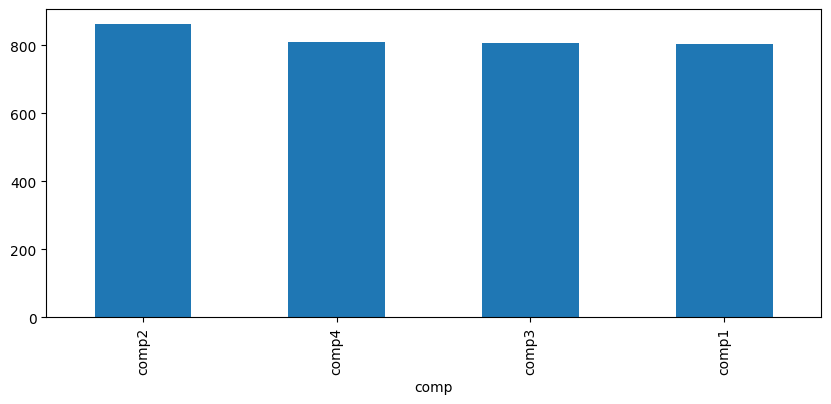

In [405]:
plt.figure(figsize=(10, 4))
maint["comp"].value_counts().plot(kind="bar")
maint["comp"].value_counts()

In [406]:
machines.head()

,machineID,model,age
0,1,model3,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model3,2


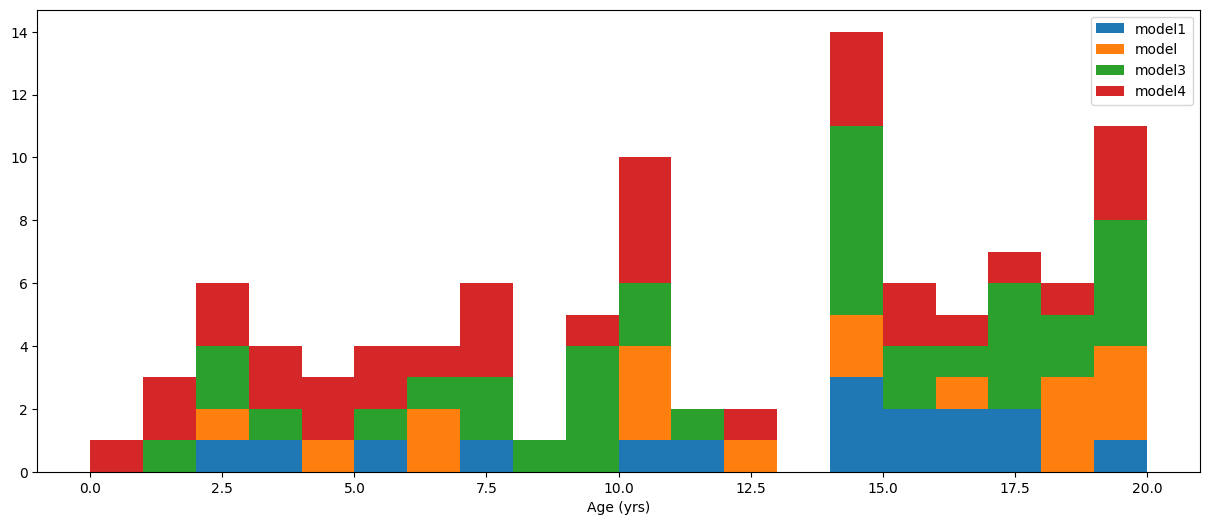

In [407]:
plt.figure(figsize=(15, 6))
_, bins, _ = plt.hist([machines.loc[machines["model"] == "model1", "age"],
                       machines.loc[machines["model"] == "model2", "age"],
                       machines.loc[machines["model"] == "model3", "age"],
                       machines.loc[machines["model"] == "model4", "age"]],
                       20, stacked=True, label=["model1", "model", "model3", "model4"])
plt.xlabel("Age (yrs)")
plt.legend()

In [408]:
failures.head()

,datetime,machineID,failure
0,2015-01-05 06:00:00,1,comp4
1,2015-03-06 06:00:00,1,comp1
2,2015-04-20 06:00:00,1,comp2
3,2015-06-19 06:00:00,1,comp4
4,2015-09-02 06:00:00,1,comp4


failure
comp2    259
comp1    192
comp4    179
comp3    131
Name: count, dtype: int64

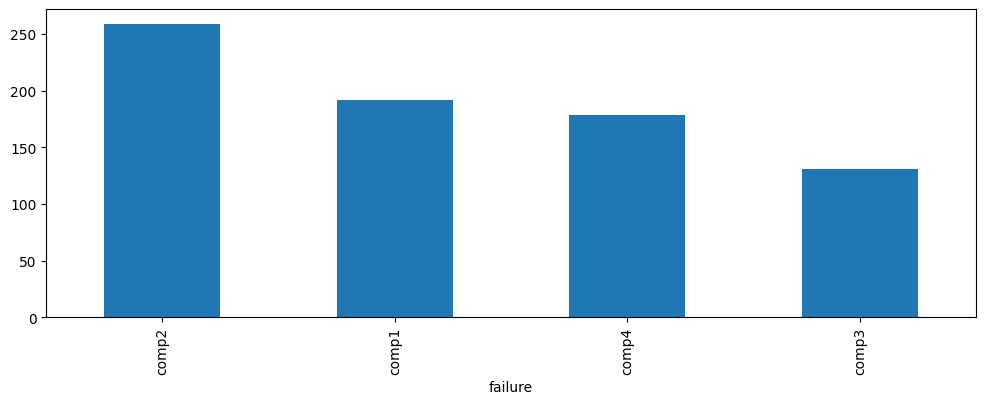

In [409]:
plt.figure(figsize=(12, 4))
failures["failure"].value_counts().plot(kind="bar")
failures["failure"].value_counts()

## Шаг 2: Feature Engineering

Примечание: 

Этот датасет не содержит пропусков, поэтому этап импутации (LSTM encoder-decoder) можно опустить. Временные окна есть.

2.1 Скользящие средние и STD (3h и 24h)

In [410]:
# Сводка по машинам и времени
telemetry["datetime"] = pd.to_datetime(telemetry["datetime"])

# Усредняем по машинам и времени с шагом 3 часа
telemetry["datetime_3h"] = telemetry["datetime"].dt.floor("3H")

# Список признаков
fields = ["volt", "rotate", "pressure", "vibration"]

# 3H признаки
temp_mean_3h, temp_std_3h = [], []
for col in fields:
    pt = pd.pivot_table(telemetry, index="datetime", columns="machineID", values=col)
    # Ресемплируем до 3-часовых интервалов
    resampled = pt.resample('3H', closed='left', label='right')
    temp_mean_3h.append(resampled.mean().unstack())
    temp_std_3h.append(resampled.std().unstack())

telemetry_mean_3h = pd.concat(temp_mean_3h, axis=1)
telemetry_mean_3h.columns = [f"{col}mean_3h" for col in fields]

telemetry_sd_3h = pd.concat(temp_std_3h, axis=1)
telemetry_sd_3h.columns = [f"{col}sd_3h" for col in fields]

# Сбрасываем индекс, чтобы machineID и datetime стали колонками
telemetry_mean_3h = telemetry_mean_3h.reset_index()
telemetry_sd_3h = telemetry_sd_3h.reset_index()

# 24H признаки
temp_mean_24h, temp_std_24h = [], []
for col in fields:
    pt = pd.pivot_table(telemetry, index="datetime", columns="machineID", values=col)
    # Скользящее окно 24 часа (24 записи при часовой частоте)
    rolling_mean = pt.rolling(window=24, min_periods=1).mean()
    rolling_std = pt.rolling(window=24, min_periods=1).std()
    # Ресемплируем каждые 3 часа, берём первое значение окна
    temp_mean_24h.append(rolling_mean.resample("3H", closed="left", label="right").first().unstack())
    temp_std_24h.append(rolling_std.resample("3H", closed="left", label="right").first().unstack())

telemetry_mean_24h = pd.concat(temp_mean_24h, axis=1)
telemetry_mean_24h.columns = [f"{col}mean_24h" for col in fields]
telemetry_mean_24h = telemetry_mean_24h.reset_index()

telemetry_sd_24h = pd.concat(temp_std_24h, axis=1)
telemetry_sd_24h.columns = [f"{col}sd_24h" for col in fields]
telemetry_sd_24h = telemetry_sd_24h.reset_index()

# Удаляем строки, где 24h статистика не определена (NaN)
telemetry_mean_24h = telemetry_mean_24h.dropna(subset=[f"{fields[0]}mean_24h"])
telemetry_sd_24h = telemetry_sd_24h.dropna(subset=[f"{fields[0]}sd_24h"])

In [411]:
# Объединение всех признаков
# Берём machineID и datetime из telemetry_mean_3h
telemetry_feat = telemetry_mean_3h.copy()

# Добавляем остальные признаки 
for df in [telemetry_sd_3h, telemetry_mean_24h, telemetry_sd_24h]:
    # Исключаем колонки machineID и datetime при слиянии
    telemetry_feat = telemetry_feat.merge(df, on=["machineID", "datetime"], how="inner")

# Удаляем оставшиеся NaN 
telemetry_feat = telemetry_feat.dropna()

telemetry_feat.describe()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
count,292000.000000,292000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000
mean,50.500000,2015-07-02 19:30:00.000000256,170.777300,446.605807,100.858510,40.384920,13.299090,44.456338,8.885976,4.441164,170.777432,446.604867,100.858878,40.384597,14.915961,49.943867,10.046078,5.001976
min,1.000000,2015-01-01 09:00:00,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,136.878588,266.010419,76.005332,22.973289,0.029992,0.750946,0.156141,0.016414
25%,25.750000,2015-04-02 14:15:00,164.449510,427.560977,96.238546,38.147765,8.027455,26.903705,5.370581,2.684790,168.069944,441.536242,98.667448,39.353089,13.355848,44.660097,8.922924,4.459796
50%,50.500000,2015-07-02 19:30:00,170.434378,448.382261,100.234191,40.145837,12.495658,41.794719,8.346020,4.173955,170.212055,449.210337,100.098223,40.072764,14.852462,49.611770,9.921189,4.958575
75%,75.250000,2015-10-02 00:45:00,176.611778,468.448505,104.406557,42.227559,17.688490,59.104130,11.790303,5.900106,172.463410,456.371174,101.613838,40.834217,16.394635,54.825130,10.981148,5.485249
max,100.000000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,223.853296,576.923563,153.422157,61.932124,50.025809,161.679341,28.901987,13.203534
std,28.866119,NaN,9.500846,33.130042,7.414517,3.478823,6.965914,23.216712,4.656211,2.320302,4.736335,18.113897,4.751079,2.065360,2.271532,7.724405,1.720314,0.803358


In [412]:
telemetry_feat.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970,176.217853,418.504078,113.077935,45.087686,9.431836,11.141591,12.457390,1.183494
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891,7.596570,50.120452,8.555032,7.662229,168.137453,423.687682,98.256232,40.950662,6.665324,75.770259,17.109194,4.798255
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405,10.124584,55.084734,5.909721,5.169304,165.602958,437.074655,101.799186,38.314585,7.663161,60.321814,13.926919,6.776542
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739,4.673269,42.047278,4.554047,2.106108,167.628643,432.864675,102.906797,38.906813,7.201655,52.122115,11.734582,6.091345
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542,14.752132,47.048609,4.244158,2.207884,165.920374,434.606729,101.180158,39.568936,7.567359,50.433677,11.284286,5.550047


2.2 Добавление Trend Features

In [413]:
# Уже есть: telemetry_mean_3h, telemetry_mean_24h
# Создадим признаки тренда: разница между 24h и 3h средними

for col in fields:
    short_mean = f"{col}mean_3h"
    long_mean = f"{col}mean_24h"
    trend_col = f"{col}_trend"
    telemetry_feat[trend_col] = telemetry_feat[long_mean] - telemetry_feat[short_mean]

    # Аналогично для стандартного отклонения
    short_std = f"{col}sd_3h"
    long_std = f"{col}sd_24h"
    trend_std_col = f"{col}_trend_sd"
    telemetry_feat[trend_std_col] = telemetry_feat[long_std] - telemetry_feat[short_std]

2.3 Добавление FFT Features

In [414]:
from scipy.fft import rfft, rfftfreq

def compute_fft_features(signal, n_peaks=2):
    N = len(signal)
    if N < 2:
        return np.zeros(2 * n_peaks)
    
    # Убираем DC-компонент (среднее)
    signal = signal - np.mean(signal)
    yf = np.abs(rfft(signal))
    xf = rfftfreq(N, d=1.0)  # Шаг = 1 (условные единицы)
    
    # Находим индексы топ-n пиков
    peak_indices = np.argsort(yf)[-n_peaks:][::-1]
    top_freqs = xf[peak_indices]
    top_amps = yf[peak_indices]
    
    # Конкатенируем и обрезаем/дополняем до 2 * n_peaks
    result = np.concatenate([top_freqs, top_amps])
    if len(result) < 2 * n_peaks:
        result = np.pad(result, (0, 2 * n_peaks - len(result)), constant_values=0)
    elif len(result) > 2 * n_peaks:
        result = result[:2 * n_peaks]

    return result

# Добавляем FFT-признаки
fft_features_list = []
window_size = 24  # Последние 24 записи (~24 ч)

for mid in telemetry["machineID"].unique():
    sub = telemetry[telemetry["machineID"] == mid].copy()
    sub = sub.sort_values("datetime")
    
    for i in range(window_size, len(sub) + 1):
        window = sub.iloc[i - window_size:i]
        row = {"machineID": mid, "datetime": window["datetime"].iloc[-1]}
        
        for col in fields:
            signal = window[col].values
            fft_vals = compute_fft_features(signal, n_peaks=2)
            for j in range(len(fft_vals)):
                row[f"{col}_fft{j}"] = fft_vals[j]
        
        fft_features_list.append(row)

# Создаём датафрейм и объединяем
fft_df = pd.DataFrame(fft_features_list)
telemetry_feat = telemetry_feat.merge(fft_df, on=["machineID", "datetime"], how="left")
telemetry_feat = telemetry_feat.fillna(0)  

2.4 Нормализация FFT-признаков

In [415]:
# Найдём все FFT-колонки
fft_cols = [col for col in telemetry_feat.columns if 'fft' in col]

# Применим StandardScaler только к FFT-признакам
scaler_fft = StandardScaler()
telemetry_feat[fft_cols] = scaler_fft.fit_transform(telemetry_feat[fft_cols])

 Это гарантирует, что FFT-признаки имеют среднее ≈ 0 и std ≈ 1, как и исходные признаки (mean_3h, sd_24h и т.д.).

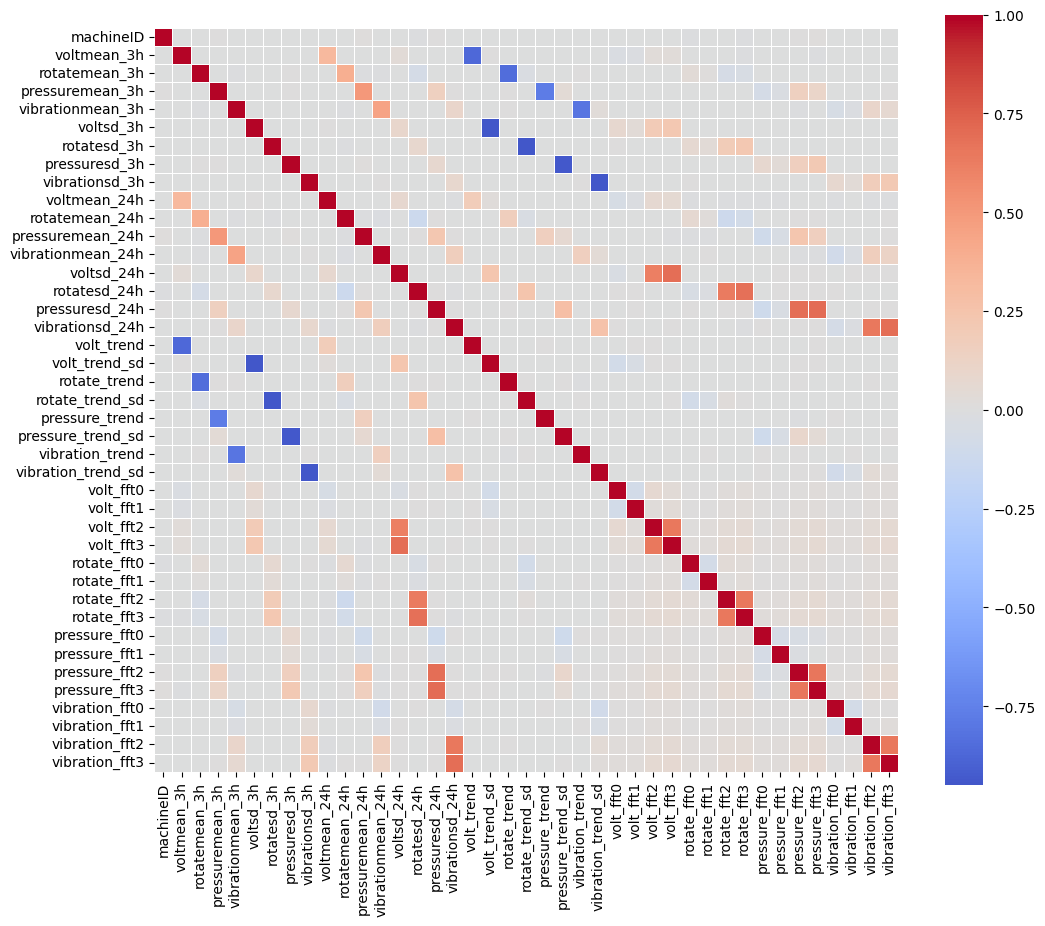

In [416]:
# Визуализация корреляции (для отладки)
plt.figure(figsize=(12, 10))
sns.heatmap(telemetry_feat.select_dtypes(include=[np.number]).corr(), 
            cmap='coolwarm', center=0, square=True, linewidths=0.5)
plt.show()

Признаки действительно слабо коррелируют, так как telemetry_feat включает разные физические величины. Но проверить стоило. 

2.6 Ошибки (подсчёт за 24h)

In [417]:
# Убедимся, что у нас есть machineID и datetime
errors["datetime"] = pd.to_datetime(errors["datetime"])
errors["datetime_3h"] = errors["datetime"].dt.floor("3H")

# Преобразуем errorID в числовые метки
errors["errorID"] = errors["errorID"].str.replace("error", "").astype(int)

# Создаём one-hot кодирование
error_dummies = pd.get_dummies(errors, columns=["errorID"], prefix="error")

# Группируем по machineID и 3-часовому времени, суммируя только числовые колонки (ошибки)
# Исключаем исходные нечисловые колонки (datetime, errorID)
id_cols = ["machineID", "datetime_3h"]
error_cols = [col for col in error_dummies.columns if col.startswith("error_")]

# Агрегируем по machineID и усреднённому времени
error_grouped = error_dummies.groupby(id_cols)[error_cols].sum().reset_index()

# Создаём 24H скользящее окно (8 окон по 3 ч)
# Для этого сначала сделаем pivot, чтобы применить rolling
temp = []
for col in error_cols:
    # Поворачиваем таблицу: строки = datetime_3h, колонки = machineID
    pt = pd.pivot_table(
        error_grouped,
        index="datetime_3h",
        columns="machineID",
        values=col,
        fill_value=0
    )
    # Скользящая сумма за 24 часа 
    rolling_sum = pt.rolling(window=8, min_periods=1).sum()
    # Ресемплируем каждые 3 часа 
    # Берём первое значение (оно же единственное) в каждом 3H интервале
    resampled = rolling_sum.resample("3H", closed="left", label="right").first()
    # Возвращаем в длинный формат
    temp.append(resampled.unstack())

# Объединяем все типы ошибок
error_count = pd.concat(temp, axis=1)
error_count.columns = [f"error{i}count" for i in range(1, 6)]

# Сбрасываем индекс, чтобы machineID и datetime стали колонками
error_count = error_count.reset_index()
error_count.rename(columns={"datetime_3h": "datetime"}, inplace=True)

# Удаляем строки, где нет данных 
error_count = error_count.dropna()

error_count.describe()

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
count,195400.000000,195400,195400.000000,195400.000000,195400.000000,195400.000000,195400.000000
mean,50.500000,2015-07-02 11:45:32.241555712,0.041351,0.040409,0.034186,0.029724,0.014575
min,1.000000,2015-01-01 09:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,2015-03-31 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.500000,2015-07-02 19:30:00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.250000,2015-10-01 21:00:00,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,2016-01-01 06:00:00,2.000000,3.000000,2.000000,2.000000,2.000000
std,28.866144,NaN,0.202971,0.200702,0.184835,0.171951,0.120823


In [418]:
error_count.head()

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
0,1,2015-01-01 09:00:00,0.0,0.0,0.0,0.0,0.0
1,1,2015-01-01 12:00:00,0.0,0.0,0.0,0.0,0.0
2,1,2015-01-01 15:00:00,0.0,0.0,0.0,0.0,0.0
4,1,2015-01-01 21:00:00,0.0,0.0,0.0,0.0,0.0
6,1,2015-01-02 03:00:00,0.0,0.0,0.0,0.0,0.0


2.7 Дни с последней замены компонента

In [419]:
# Подготовка maint
comp_rep = pd.get_dummies(maint.set_index("datetime")).reset_index()
comp_rep.columns = ["datetime", "machineID", "comp1", "comp2", "comp3", "comp4"]

# Агрегируем по machineID и datetime
comp_rep  = comp_rep.groupby(["machineID", "datetime"]).sum().reset_index()

# Добавляем временные точки, где не было замен
comp_rep = telemetry[["datetime", "machineID"]].merge(comp_rep,
                                                      on=["datetime", "machineID"],
                                                      how="outer").fillna(0).sort_values(by=["machineID", "datetime"])  # Сортируем по машине и времени 

# Вычисляем дни с последней замены для каждого компонента
comp_cols = ["comp1", "comp2", "comp3", "comp4"]
for comp in comp_cols:
    # Создаём бинарный флаг: была ли замена?
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), "datetime"]
    
    # Заполняем с датой последней замены компонента (по машинам)
    comp_rep[comp] = comp_rep[comp].fillna(method="ffill")

# Удаляем данные до 2015 года
comp_rep = comp_rep[comp_rep["datetime"] >= pd.to_datetime("2015-01-01")].reset_index(drop=True)
for comp in comp_cols:
    comp_rep[comp] = (comp_rep["datetime"] - comp_rep[comp]) / np.timedelta64(1, "D")

comp_rep.describe()

,datetime,machineID,comp1,comp2,comp3,comp4
count,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,2015-07-02 18:00:00,50.500000,53.525185,51.540806,52.725962,53.834191
min,2015-01-01 06:00:00,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-04-02 12:00:00,25.750000,13.291667,12.125000,13.125000,13.000000
50%,2015-07-02 18:00:00,50.500000,32.791667,29.666667,32.291667,32.500000
75%,2015-10-02 00:00:00,75.250000,68.708333,66.541667,67.333333,70.458333
max,2016-01-01 06:00:00,100.000000,491.958333,348.958333,370.958333,394.958333
std,NaN,28.866087,62.491679,59.269254,58.873114,59.707978


In [420]:
comp_rep.head()

,datetime,machineID,comp1,comp2,comp3,comp4
0,2015-01-01 06:00:00,1,19.000000,214.000000,154.000000,169.000000
1,2015-01-01 07:00:00,1,19.041667,214.041667,154.041667,169.041667
2,2015-01-01 08:00:00,1,19.083333,214.083333,154.083333,169.083333
3,2015-01-01 09:00:00,1,19.125000,214.125000,154.125000,169.125000
4,2015-01-01 10:00:00,1,19.166667,214.166667,154.166667,169.166667


2.8 Объединение всех признаков

In [421]:
# Слияние
final_feat = telemetry_feat.merge(error_count, on=["machineID", "datetime"], how="left")
final_feat = final_feat.merge(comp_rep, on=["machineID", "datetime"], how="left")
final_feat = final_feat.merge(machines, on="machineID", how="left")
final_feat = final_feat.fillna(0)

# One-hot кодирование 'model'
final_feat = pd.get_dummies(final_feat, columns=["model"], prefix="model")
final_feat.describe()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error1count,error2count,error3count,error4count,error5count,comp1,comp2,comp3,comp4,age
count,292000.000000,292000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,...,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000
mean,50.500000,2015-07-02 19:30:00.000000256,170.777300,446.605807,100.858510,40.384920,13.299090,44.456338,8.885976,4.441164,...,0.027671,0.027041,0.022877,0.019890,0.009753,53.464473,51.475866,52.660493,53.769068,11.330000
min,1.000000,2015-01-01 09:00:00,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,2015-04-02 14:15:00,164.449510,427.560977,96.238546,38.147765,8.027455,26.903705,5.370581,2.684790,...,0.000000,0.000000,0.000000,0.000000,0.000000,13.250000,12.125000,13.125000,13.000000,6.750000
50%,50.500000,2015-07-02 19:30:00,170.434378,448.382261,100.234191,40.145837,12.495658,41.794719,8.346020,4.173955,...,0.000000,0.000000,0.000000,0.000000,0.000000,32.750000,29.625000,32.250000,32.500000,12.000000
75%,75.250000,2015-10-02 00:45:00,176.611778,468.448505,104.406557,42.227559,17.688490,59.104130,11.790303,5.900106,...,0.000000,0.000000,0.000000,0.000000,0.000000,68.625000,66.500000,67.250000,70.375000,16.000000
max,100.000000,2016-01-01 06:00:00,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,...,2.000000,3.000000,2.000000,2.000000,2.000000,491.875000,348.875000,370.875000,394.875000,20.000000
std,28.866119,NaN,9.500846,33.130042,7.414517,3.478823,6.965914,23.216712,4.656211,2.320302,...,0.167173,0.165278,0.152054,0.141355,0.099075,62.479594,59.251179,58.856793,59.692723,5.827625


In [422]:
final_feat.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,error5count,comp1,comp2,comp3,comp4,age,model_model1,model_model2,model_model3,model_model4
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970,...,0.0,19.125,214.125,154.125,169.125,18,False,False,True,False
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891,7.596570,50.120452,8.555032,7.662229,...,0.0,19.250,214.250,154.250,169.250,18,False,False,True,False
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405,10.124584,55.084734,5.909721,5.169304,...,0.0,19.375,214.375,154.375,169.375,18,False,False,True,False
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739,4.673269,42.047278,4.554047,2.106108,...,0.0,19.500,214.500,154.500,169.500,18,False,False,True,False
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542,14.752132,47.048609,4.244158,2.207884,...,0.0,19.625,214.625,154.625,169.625,18,False,False,True,False


2.9 Присоединение отказов 

In [423]:
# Сортировка и объединение отказов с признаками по времени
failures["datetime"] = pd.to_datetime(failures["datetime"])
failures = failures.sort_values(["machineID", "datetime"])

# Список всех отказов
failure_records = []

for _, row in failures.iterrows():
    mid = row["machineID"]
    t_fail = row["datetime"]
    comp = row["failure"]
    
    # Выбираем признаки за 24 часа до отказа
    window_start = t_fail - pd.Timedelta(hours=24)
    window_features = final_feat[
        (final_feat["machineID"] == mid) &
        (final_feat["datetime"] >= window_start) &
        (final_feat["datetime"] < t_fail)
    ].copy()
    
    # Каждая строка в окне отдельный объект с меткой отказа
    window_features["failure"] = comp
    failure_records.append(window_features)

# Объединяем все положительные окна
positive_samples = pd.concat(failure_records, ignore_index=True)

# Добавляем случайные отрицательные примеры без отказа
# Сначала определим все временные точки, где нет отказа в будущем 24h
all_times = final_feat[["machineID", "datetime"]].copy()
all_times = all_times.merge(failures, on=["machineID", "datetime"], how="left")
all_times = all_times[all_times["failure"].isna()]  # Нет отказа именно в этот момент

# Убираем точки, где в следующие 24h есть отказ
def has_failure_in_next_24h(row, failures_df):
    t = row["datetime"]
    mid = row["machineID"]
    future_fails = failures_df[
        (failures_df["machineID"] == mid) &
        (failures_df["datetime"] > t) &
        (failures_df["datetime"] <= t + pd.Timedelta(hours=24))
    ]
    return not future_fails.empty

all_times["has_future_fail"] = all_times.apply(
    lambda r: has_failure_in_next_24h(r, failures), axis=1
)
negative_candidates = all_times[~all_times["has_future_fail"]]

# Выбираем случайные точки 
# Например, в 3 раза больше, чем положительных
n_pos = len(positive_samples)
n_neg = min(3 * n_pos, len(negative_candidates))
negative_samples = negative_candidates.sample(n=n_neg, random_state=42).copy()
negative_samples = negative_samples.merge(final_feat, on=["machineID", "datetime"], how="left")
negative_samples["failure"] = "none"

# Объединяем
labeled_features_clean = pd.concat([positive_samples, negative_samples], ignore_index=True)
labeled_features = labeled_features_clean.dropna(subset=["failure"])
labeled_features.head()

,machineID,datetime,voltmean_3h,rotatemean_3h,pressuremean_3h,vibrationmean_3h,voltsd_3h,rotatesd_3h,pressuresd_3h,vibrationsd_3h,...,comp2,comp3,comp4,age,model_model1,model_model2,model_model3,model_model4,failure,has_future_fail
0,1,2015-01-04 06:00:00,186.092896,451.641253,107.989359,55.308074,13.489090,62.185045,5.118176,4.904365,...,217.000,157.000,172.000,18,False,False,True,False,comp4,NaN
1,1,2015-01-04 09:00:00,166.281848,453.787824,106.187582,51.990080,24.276228,23.621315,11.176731,3.394073,...,217.125,157.125,172.125,18,False,False,True,False,comp4,NaN
2,1,2015-01-04 12:00:00,175.412103,445.450581,100.887363,54.251534,34.918687,11.001625,10.580336,2.921501,...,217.250,157.250,172.250,18,False,False,True,False,comp4,NaN
3,1,2015-01-04 15:00:00,157.347716,451.882075,101.289380,48.602686,24.617739,28.950883,9.966729,2.356486,...,217.375,157.375,172.375,18,False,False,True,False,comp4,NaN
4,1,2015-01-04 18:00:00,176.450550,446.033068,84.521555,47.638836,8.071400,76.511343,2.636879,4.108621,...,217.500,157.500,172.500,18,False,False,True,False,comp4,NaN


2.10 Визуализация дисбаланса

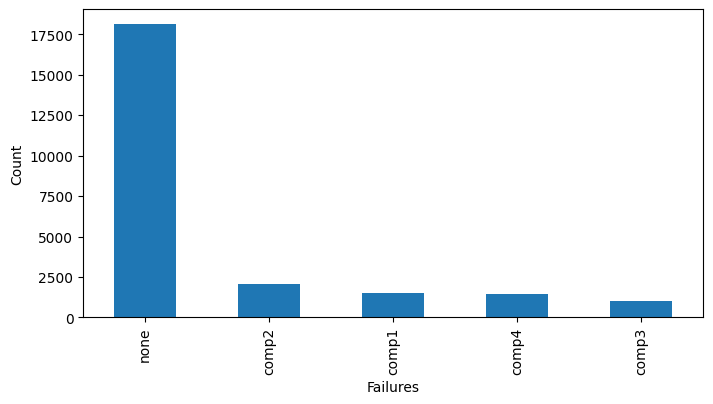

In [424]:
plt.figure(figsize=(8, 4))
labeled_features["failure"].value_counts().plot(kind="bar")
plt.xlabel("Failures")
plt.ylabel("Count")
plt.show()

2.11 Undersampling класса без отказов для нейросетей

In [425]:
# После объединения
class_counts = labeled_features["failure"].value_counts()
max_minority = class_counts.drop("none").max()

# Оставляем не более 5× от самого частого отказа
undersample_none = labeled_features[
    (labeled_features["failure"] != "none") |
    (labeled_features["failure"] == "none") &
    (labeled_features.groupby("failure").cumcount() < 5 * max_minority)
]
labeled_features = undersample_none

## Шаг 3: Глобальный временной сплит по дате

Примечание (временные ряды): 

Данные обладают **внутренней хронологической зависимостью**: будущее зависит от прошлого, но прошлое не зависит от будущего.

In [426]:
# from sklearn.model_selection import train_test_split

# # Найдём для каждой машины её основной тип отказа 
# machine_failure_types = labeled_features.groupby("machineID")["failure"].apply(
#     lambda x: x[x != "none"].iloc[0] if len(x[x != "none"]) > 0 else "none"
# ).reset_index()
# machine_failure_types.columns = ["machineID", "primary_failure"]

# # Уникальные machineID с их целевыми классами
# mids = machine_failure_types["machineID"].values
# targets = machine_failure_types["primary_failure"].values

# # Stratified split по машинам
# train_mids, val_mids = train_test_split(
#     mids, 
#     test_size=0.2, 
#     stratify=targets,  
#     random_state=42
# )

# train_mask = labeled_features["machineID"].isin(train_mids)
# val_mask = labeled_features["machineID"].isin(val_mids)

split_time = labeled_features["datetime"].quantile(0.8)
train_mask = labeled_features["datetime"] < split_time
val_mask = labeled_features["datetime"] >= split_time

## Шаг 4: Построение бинарной метки (за 24h до отказа)

In [427]:
from sklearn.preprocessing import LabelEncoder

# Признаки и метки
X = labeled_features.drop(columns=["datetime", "machineID", "failure"])
y = labeled_features["failure"]

# Кодируем метки
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) 

# One-hot кодирование оставшихся категориальных колонок
X = pd.get_dummies(X, drop_first=False)  # drop_first=False сохраняем все категории

# Train/val
X_train = X.loc[train_mask].values.astype(np.float32)
y_train = y_encoded[train_mask].astype(np.int64)

X_val = X.loc[val_mask].values.astype(np.float32)
y_val = y_encoded[val_mask].astype(np.int64)

4.1 Oversampling (RandomOverSampler)

В временных рядах SMOTE/Oversampling не рекомендуется, так как генерирует «неправдоподобные» точки во времени. 

In [428]:
# from imblearn.over_sampling import RandomOverSampler

# ros = RandomOverSampler(random_state=42)
# X_train_bal, y_train_bal = ros.fit_resample(X_train, y_train)

# print(f"Before oversampling: classes = {np.bincount(y_train)}")
# print(f"After oversampling: classes = {np.bincount(y_train_bal)}")

## Шаг 5: RUL-регрессия

Примечание: 

RUL считается по исходным данным, до оверсэмплинга, так как он используется только в регрессионной задаче, где оверсэмплинг не применяется.

Сначала создадим **метку RUL** (оставшееся время до отказа в часах):

In [429]:
# Убедимся, что данные отсортированы по времени
labeled_features = labeled_features.sort_values(["machineID", "datetime"]).reset_index(drop=True)

# Создание RUL: время до ближайшего отказа в часах
labeled_features["RUL"] = np.nan

# Для каждой машины отдельно
for mid in labeled_features["machineID"].unique():
    sub = labeled_features[labeled_features["machineID"] == mid].copy()
    # Найти все времена отказов (где failure != none)
    fail_times = sub[sub["failure"] != "none"]["datetime"]
    if len(fail_times) == 0:
        continue
    fail_times = fail_times.sort_values().values 
    
    for idx, row in sub.iterrows():
        current_time = row["datetime"]
        future_fails = fail_times[fail_times > current_time]
        if len(future_fails) > 0:
            rul_hours = (future_fails[0] - current_time).total_seconds() / 3600
            labeled_features.loc[idx, "RUL"] = max(rul_hours, 0)

# Гарантируем числовой тип RUL 
labeled_features["RUL"] = pd.to_numeric(labeled_features["RUL"], errors='coerce')
labeled_features = labeled_features.dropna(subset=["RUL"])  # Удаляем строки с NaN

# Например, только последние 168 часов (7 дней) до отказа
HORIZON_HOURS = 168
labeled_features_rul = labeled_features[
    (labeled_features["RUL"] > 0) & (labeled_features["RUL"] <= HORIZON_HOURS)
].copy()

# Определим список признаков до фильтрации (чтобы избежать утечки)
# Исключаем служебные и целевые колонки
all_cols = set(labeled_features.columns)
non_feature_cols = {"datetime", "machineID", "failure", "RUL"}
feature_cols = list(all_cols - non_feature_cols)

# Разделение по машинам 
all_mids = labeled_features_rul["machineID"].unique()
np.random.shuffle(all_mids)
n_train = int(0.8 * len(all_mids))
train_mids = set(all_mids[:n_train])
val_mids = set(all_mids[n_train:])

train_rul = labeled_features_rul[labeled_features_rul["machineID"].isin(train_mids)]
val_rul = labeled_features_rul[labeled_features_rul["machineID"].isin(val_mids)]

# Признаки и метки
feature_cols = [col for col in feature_cols if col in train_rul.columns]

# Удаление строк с NaN в признаках (X) для RUL-регрессии
train_rul_clean = train_rul.dropna(subset=feature_cols)
val_rul_clean = val_rul.dropna(subset=feature_cols)

# Обновите признаки и метки
X_train_rul = train_rul_clean[feature_cols].values.astype(np.float32)
y_train_rul = train_rul_clean["RUL"].values.astype(np.float32)

X_val_rul = val_rul_clean[feature_cols].values.astype(np.float32)
y_val_rul = val_rul_clean["RUL"].values.astype(np.float32)


## Шаг 6: Нормализация и тензоры

In [430]:
scaler_clf = StandardScaler()
X_train_scaled = scaler_clf.fit_transform(X_train)
X_val_scaled = scaler_clf.transform(X_val)

# Для регрессии 
scaler_rul = StandardScaler()
X_train_rul_scaled = scaler_rul.fit_transform(X_train_rul)
X_val_rul_scaled = scaler_rul.transform(X_val_rul)

# Тензоры для классификации 
X_train_clf_t = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_val_clf_t = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_train_clf_t = torch.tensor(y_train, dtype=torch.long).to(device)
y_val_clf_t = torch.tensor(y_val, dtype=torch.long).to(device)

# Тензоры для регрессии 
X_train_rul_t = torch.tensor(X_train_rul_scaled, dtype=torch.float32).to(device)
X_val_rul_t = torch.tensor(X_val_rul_scaled, dtype=torch.float32).to(device)
y_train_rul_t = torch.tensor(y_train_rul, dtype=torch.float32).to(device)
y_val_rul_t = torch.tensor(y_val_rul, dtype=torch.float32).to(device)

# DataLoader 
train_loader_clf = DataLoader(TensorDataset(X_train_clf_t, y_train_clf_t), batch_size=128, shuffle=False)
val_loader_clf = DataLoader(TensorDataset(X_val_clf_t, y_val_clf_t), batch_size=128, shuffle=False)

# Проверка
assert X_train_rul_t is not None, "X_train_rul_t is None!"
assert y_train_rul_t is not None, "y_train_rul_t is None!"
assert X_val_rul_t is not None, "X_val_rul_t is None!"
assert y_val_rul_t is not None, "y_val_rul_t is None!"

# Создание DataLoader
train_loader_rul = DataLoader(TensorDataset(X_train_rul_t, y_train_rul_t), batch_size=128, shuffle=False)
val_loader_rul = DataLoader(TensorDataset(X_val_rul_t, y_val_rul_t), batch_size=128, shuffle=False)

input_size = X_train.shape[1]
n_classes = 5

## Шаг 7: Модели

7.0 Калибровка вероятностей

In [431]:
from sklearn.base import BaseEstimator, ClassifierMixin

class TorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model, n_classes=5):
        self.model = model
        self.n_classes = n_classes
        self.model.eval()
    
    def fit(self, X, y):
        return self
    
    def predict_proba(self, X):
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            out = self.model(X_tensor)
            prob = torch.softmax(out, dim=1).cpu().numpy()
        return prob
    
    def predict(self, X):
        prob = self.predict_proba(X)
        return np.argmax(prob, axis=1)

7.1 Мультиклассовая Focal Loss

In [432]:
# import torch.nn.functional as F

# class FocalLoss(nn.Module):
#     def __init__(self, alpha=None, gamma=2, reduction='mean'):
#         super().__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.reduction = reduction

#     def forward(self, inputs, targets):
#         ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)  # (N, C), (N,)
#         pt = torch.exp(-ce_loss)
#         focal_loss = (1 - pt) ** self.gamma * ce_loss
#         if self.reduction == "mean":
#             return focal_loss.mean()
#         else:
#             return focal_loss

Focal Loss часто повышает precision, так как гасит переобучение на лёгких примерах отказов.

7.2 Общий класс для классификации и регрессии

In [433]:
class DLinear(nn.Module):
    def __init__(self, input_size, n_classes=5, task="classification", dropout=0.5):
        super().__init__()
        self.task = task
        self.dropout = nn.Dropout(dropout)

        # Веса для seasonal и trend компонент
        output_dim = 1 if task == "regression" else n_classes
        self.linear_seasonal = nn.Linear(input_size, output_dim)
        self.linear_trend = nn.Linear(input_size, output_dim)

    def forward(self, x):
        x = self.dropout(x)
        seasonal = self.linear_seasonal(x)
        trend = self.linear_trend(x)
        out = seasonal + trend
        if self.task == "regression":
            return out.squeeze(-1) 
        else:
            return out  # (B, n_classes)

В DLinear нет скрытых слоёв, поэтому dropout применяется к входным признакам, что снижает зависимость от ложных корреляций.

In [434]:
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, task="classification", n_classes=5, 
                 nhead=4, num_layers=1, dropout=0.5):
        super().__init__()
        self.task = task
        self.proj = nn.Linear(input_size, hidden_size)
        
        # TransformerEncoderLayer включает dropout 
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=nhead,
            dim_feedforward=128,
            dropout=dropout,      # Регуляризация внимания и FFN
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)  # Дополнительный dropout перед классификатором
        self.fc = nn.Linear(hidden_size, 1 if task == "regression" else n_classes)

    def forward(self, x):
        x = self.proj(x)               # (B, hidden_size)
        x = x.unsqueeze(1)             # (B, 1, hidden_size)
        x = self.transformer(x)        # (B, 1, hidden_size)
        x = x[:, 0, :]                 # (B, hidden_size)
        x = self.dropout(x)            # Регуляризация выхода
        return self.fc(x).squeeze(-1) if self.task == "regression" else self.fc(x)

In [435]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=16, n_classes=5, dropout=0.6, task="classification"):
        super().__init__()
        self.task = task
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1 if task == "regression" else n_classes)
        
    def forward(self, x):
        x = x.unsqueeze(1)  # (B, 1, input_size)
        _, (h, _) = self.lstm(x)  # h: (1, B, hidden_size)
        out = self.dropout(h[-1])  # (B, hidden_size)
        out = self.fc(h[-1])  # (B, 1) or (B, n_classes)
        if self.task == "regression":
            out = torch.relu(out)  # (B,)
        else:
            return out.squeeze(-1)  # (B, n_classes)

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size=16, n_classes=5, dropout=0.6, task="classification"):
        super().__init__()
        self.task = task
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1 if task == "regression" else n_classes)
    def forward(self, x):
        x = x.unsqueeze(1)
        _, h = self.gru(x)
        out = self.fc(h[-1])
        if self.task == "regression":
            return out.squeeze(-1)  
        return out.squeeze(-1)

Все модели принимают (B, F) и имитируют (B, 1, F), так как у вас уже агрегированные признаки, а не сырые временные ряды.

7.3 Обучение (единый цикл)

In [436]:
class ValueMeter(object):
    """
    Вспомогательный класс, чтобы отслеживать loss и метрику
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.sum = 0
        self.total = 0

    def add(self, value, n=1):
        self.sum += value * n
        self.total += n

    def value(self):
        return self.sum / self.total if self.total > 0 else float('nan')

def log(mode, epoch, loss_meter, f1_meter):
    """
    Логирует loss и accuracy 
    """
    print(
        f'[{mode}] Epoch: {epoch+1:02d}. '
        f'Loss: {loss_meter.value():.4f}. '
        f'F1: {100 * f1_meter.value():.2f}%'
    )

In [437]:
def Evaluate(model, train_loader, val_loader, task="classification", epochs=50, y_train=None):
    device = next(model.parameters()).device
    best_val_score = -float('inf')  # Будет F1 (max) или -MAE (max при инверсии)
    patience = 10
    counter = 0
    best_model_state = copy.deepcopy(model.state_dict())

    # Определение loss
    if task == "classification":
        class_counts = np.bincount(y_train)
        weights = 1.0 / class_counts
        weights = weights / weights.sum() * len(class_counts)
        class_weights = torch.FloatTensor(weights).to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
    else:
        criterion = nn.HuberLoss(delta=1.0)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)

    # История
    train_losses, val_losses = [], []
    train_scores, val_scores = [], []

    for epoch in range(epochs):
        # Обучение 
        model.train()
        train_loss_meter = ValueMeter()
        all_preds, all_trues = [], []

        for X, y in tqdm(train_loader, desc=f"Train {epoch+1}/{epochs}"):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss_meter.add(loss.item(), X.size(0))

            if task == "classification":
                preds = out.argmax(dim=1)
                all_preds.append(preds.cpu().numpy())
                all_trues.append(y.cpu().numpy())

        # Метрика на трейне
        if task == "classification":
            all_preds = np.concatenate(all_preds)
            all_trues = np.concatenate(all_trues)
            train_score = f1_score(all_trues, all_preds, average='macro', zero_division=0)
        else:
            train_score = 0.0
        train_scores.append(train_score)
        train_losses.append(train_loss_meter.value())

        # Логирование
        if task == "classification":
            f1_meter_train = ValueMeter()
            f1_meter_train.add(train_score)
            log("Train", epoch, train_loss_meter, f1_meter_train)
        else:
            log("Train", epoch, train_loss_meter, ValueMeter())
        
        # Валидация 
        model.eval()
        val_loss_meter = ValueMeter()
        all_val_preds, all_val_trues = [], []

        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                out = model(X)
                loss = criterion(out, y)
                val_loss_meter.add(loss.item(), X.size(0))

                if task == "classification":
                    preds = out.argmax(dim=1)
                    all_val_preds.append(preds.cpu().numpy())
                    all_val_trues.append(y.cpu().numpy())
                else:
                    all_val_preds.append(out.cpu().numpy())
                    all_val_trues.append(y.cpu().numpy())

        # Метрика на валидации
        if task == "classification":
            all_val_preds = np.concatenate(all_val_preds)
            all_val_trues = np.concatenate(all_val_trues)
            val_score = f1_score(all_val_trues, all_val_preds, average='macro', zero_division=0)
        else:
            all_val_preds = np.concatenate(all_val_preds)
            all_val_trues = np.concatenate(all_val_trues)
            
            valid_mask = ~np.isnan(all_val_preds) & ~np.isnan(all_val_trues)
            if valid_mask.sum() == 0:
                val_score = -float('inf')  
            else:
                val_score = -val_loss_meter.value()  # Максимизируем отрицательный loss

        val_scores.append(val_score)
        val_losses.append(val_loss_meter.value())

        if task == "classification":
            f1_meter_val = ValueMeter()
            f1_meter_val.add(val_score)
            log("Val", epoch, val_loss_meter, f1_meter_val)
        else:
            log("Val", epoch, val_loss_meter, ValueMeter())

        # Early Stopping 
        if val_score > best_val_score:
            best_val_score = val_score
            counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping на эпохе {epoch+1}")
                break

    # Загрузка лучшей модели
    model.load_state_dict(best_model_state)
    model.eval()

    # Финальное предсказание
    preds = []
    with torch.no_grad():
        for X, _ in val_loader:
            X = X.to(device)
            out = model(X)
            if task == "classification":
                prob = torch.softmax(out, dim=1).cpu().numpy()
                preds.append(prob)
            else:
                preds.append(out.cpu().numpy())
                
    preds = np.concatenate(preds, axis=0)

    return preds, {
        "train_loss": train_losses,
        "val_loss": val_losses,
        "train_score": train_scores,
        "val_score": val_scores,
        "best_val_score": best_val_score
    }

## Шаг 8: Классификация

8.0 DummyClassifier

In [438]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="stratified")
dummy.fit(X_train, y_train)

print("Dummy Val F1:", f1_score(y_val, dummy.predict(X_val), average="macro"))

Dummy Val F1: 0.20068487315922517


8.1 LSTM/GRU (нейросеть)

In [439]:
# Модель
lstm_model = LSTMModel(input_size, hidden_size=32, n_classes=5, dropout=0.6, task="classification").to(device)

# Обучение
y_score, history = Evaluate(lstm_model, train_loader_clf, val_loader_clf, y_train=y_train_clf_t, task="classification", epochs=200)  # (N, 5)

# Для каждого класса настраиваем свой порог
best_thresholds = [0.5]  
for class_id in [1, 2, 3, 4]:
    # Оптимизация под F2-score (recall-ориентированный)
    f2_scores = [
        fbeta_score(
            (y_val == class_id).astype(int),
            (y_score[:, class_id] > t).astype(int),
            beta=2, zero_division=0
        )
        for t in np.linspace(0.1, 0.9, 100)
    ]
    best_t = np.linspace(0.1, 0.9, 100)[np.argmax(f2_scores)]
    best_thresholds.append(best_t)

# Предсказание
adjusted_scores = y_score / np.array(best_thresholds)
y_pred = np.argmax(adjusted_scores, axis=1)

Train 1/200: 100%|██████████| 103/103 [00:00<00:00, 984.99it/s]


[Train] Epoch: 01. Loss: 1.4022. F1: 50.51%
[Val] Epoch: 01. Loss: 1.0896. F1: 73.16%


Train 2/200: 100%|██████████| 103/103 [00:00<00:00, 1391.53it/s]


[Train] Epoch: 02. Loss: 0.7985. F1: 82.14%
[Val] Epoch: 02. Loss: 0.5387. F1: 84.12%


Train 3/200: 100%|██████████| 103/103 [00:00<00:00, 1400.99it/s]


[Train] Epoch: 03. Loss: 0.4402. F1: 89.04%
[Val] Epoch: 03. Loss: 0.3157. F1: 90.92%


Train 4/200: 100%|██████████| 103/103 [00:00<00:00, 1411.54it/s]


[Train] Epoch: 04. Loss: 0.2601. F1: 92.97%
[Val] Epoch: 04. Loss: 0.2017. F1: 93.03%


Train 5/200: 100%|██████████| 103/103 [00:00<00:00, 1420.87it/s]


[Train] Epoch: 05. Loss: 0.1666. F1: 93.98%
[Val] Epoch: 05. Loss: 0.1464. F1: 93.38%


Train 6/200: 100%|██████████| 103/103 [00:00<00:00, 1428.45it/s]


[Train] Epoch: 06. Loss: 0.1204. F1: 94.46%
[Val] Epoch: 06. Loss: 0.1173. F1: 93.67%


Train 7/200: 100%|██████████| 103/103 [00:00<00:00, 1412.97it/s]


[Train] Epoch: 07. Loss: 0.0950. F1: 94.65%
[Val] Epoch: 07. Loss: 0.1001. F1: 93.94%


Train 8/200: 100%|██████████| 103/103 [00:00<00:00, 1422.81it/s]


[Train] Epoch: 08. Loss: 0.0796. F1: 94.86%
[Val] Epoch: 08. Loss: 0.0891. F1: 94.02%


Train 9/200: 100%|██████████| 103/103 [00:00<00:00, 1426.44it/s]


[Train] Epoch: 09. Loss: 0.0697. F1: 94.86%
[Val] Epoch: 09. Loss: 0.0816. F1: 94.12%


Train 10/200: 100%|██████████| 103/103 [00:00<00:00, 1425.29it/s]


[Train] Epoch: 10. Loss: 0.0629. F1: 94.93%
[Val] Epoch: 10. Loss: 0.0763. F1: 94.15%


Train 11/200: 100%|██████████| 103/103 [00:00<00:00, 1426.53it/s]


[Train] Epoch: 11. Loss: 0.0581. F1: 95.01%
[Val] Epoch: 11. Loss: 0.0723. F1: 94.15%


Train 12/200: 100%|██████████| 103/103 [00:00<00:00, 1434.98it/s]


[Train] Epoch: 12. Loss: 0.0545. F1: 95.04%
[Val] Epoch: 12. Loss: 0.0693. F1: 94.24%


Train 13/200: 100%|██████████| 103/103 [00:00<00:00, 1420.97it/s]


[Train] Epoch: 13. Loss: 0.0518. F1: 95.09%
[Val] Epoch: 13. Loss: 0.0671. F1: 94.30%


Train 14/200: 100%|██████████| 103/103 [00:00<00:00, 1429.23it/s]


[Train] Epoch: 14. Loss: 0.0496. F1: 95.10%
[Val] Epoch: 14. Loss: 0.0653. F1: 94.30%


Train 15/200: 100%|██████████| 103/103 [00:00<00:00, 1418.08it/s]


[Train] Epoch: 15. Loss: 0.0479. F1: 95.15%
[Val] Epoch: 15. Loss: 0.0639. F1: 94.30%


Train 16/200: 100%|██████████| 103/103 [00:00<00:00, 1429.70it/s]


[Train] Epoch: 16. Loss: 0.0466. F1: 95.23%
[Val] Epoch: 16. Loss: 0.0627. F1: 94.30%


Train 17/200: 100%|██████████| 103/103 [00:00<00:00, 1428.75it/s]


[Train] Epoch: 17. Loss: 0.0454. F1: 95.23%
[Val] Epoch: 17. Loss: 0.0618. F1: 94.30%


Train 18/200: 100%|██████████| 103/103 [00:00<00:00, 1424.37it/s]


[Train] Epoch: 18. Loss: 0.0445. F1: 95.24%
[Val] Epoch: 18. Loss: 0.0611. F1: 94.35%


Train 19/200: 100%|██████████| 103/103 [00:00<00:00, 1429.72it/s]


[Train] Epoch: 19. Loss: 0.0437. F1: 95.23%
[Val] Epoch: 19. Loss: 0.0605. F1: 94.36%


Train 20/200: 100%|██████████| 103/103 [00:00<00:00, 1427.28it/s]


[Train] Epoch: 20. Loss: 0.0430. F1: 95.25%
[Val] Epoch: 20. Loss: 0.0600. F1: 94.36%


Train 21/200: 100%|██████████| 103/103 [00:00<00:00, 1430.38it/s]


[Train] Epoch: 21. Loss: 0.0425. F1: 95.25%
[Val] Epoch: 21. Loss: 0.0596. F1: 94.36%


Train 22/200: 100%|██████████| 103/103 [00:00<00:00, 1416.69it/s]


[Train] Epoch: 22. Loss: 0.0419. F1: 95.25%
[Val] Epoch: 22. Loss: 0.0593. F1: 94.36%


Train 23/200: 100%|██████████| 103/103 [00:00<00:00, 1425.68it/s]


[Train] Epoch: 23. Loss: 0.0415. F1: 95.26%
[Val] Epoch: 23. Loss: 0.0590. F1: 94.36%


Train 24/200: 100%|██████████| 103/103 [00:00<00:00, 1431.65it/s]


[Train] Epoch: 24. Loss: 0.0411. F1: 95.26%
[Val] Epoch: 24. Loss: 0.0588. F1: 94.36%


Train 25/200: 100%|██████████| 103/103 [00:00<00:00, 1437.28it/s]


[Train] Epoch: 25. Loss: 0.0408. F1: 95.27%
[Val] Epoch: 25. Loss: 0.0586. F1: 94.36%


Train 26/200: 100%|██████████| 103/103 [00:00<00:00, 1431.32it/s]


[Train] Epoch: 26. Loss: 0.0405. F1: 95.27%
[Val] Epoch: 26. Loss: 0.0585. F1: 94.47%


Train 27/200: 100%|██████████| 103/103 [00:00<00:00, 1430.12it/s]


[Train] Epoch: 27. Loss: 0.0402. F1: 95.30%
[Val] Epoch: 27. Loss: 0.0583. F1: 94.47%


Train 28/200: 100%|██████████| 103/103 [00:00<00:00, 1431.09it/s]


[Train] Epoch: 28. Loss: 0.0399. F1: 95.32%
[Val] Epoch: 28. Loss: 0.0582. F1: 94.47%


Train 29/200: 100%|██████████| 103/103 [00:00<00:00, 989.53it/s]


[Train] Epoch: 29. Loss: 0.0397. F1: 95.32%
[Val] Epoch: 29. Loss: 0.0581. F1: 94.47%


Train 30/200: 100%|██████████| 103/103 [00:00<00:00, 1431.13it/s]


[Train] Epoch: 30. Loss: 0.0395. F1: 95.32%
[Val] Epoch: 30. Loss: 0.0580. F1: 94.47%


Train 31/200: 100%|██████████| 103/103 [00:00<00:00, 1439.69it/s]


[Train] Epoch: 31. Loss: 0.0392. F1: 95.35%
[Val] Epoch: 31. Loss: 0.0579. F1: 94.41%


Train 32/200: 100%|██████████| 103/103 [00:00<00:00, 1427.50it/s]


[Train] Epoch: 32. Loss: 0.0391. F1: 95.35%
[Val] Epoch: 32. Loss: 0.0578. F1: 94.41%


Train 33/200: 100%|██████████| 103/103 [00:00<00:00, 1434.50it/s]


[Train] Epoch: 33. Loss: 0.0389. F1: 95.35%
[Val] Epoch: 33. Loss: 0.0577. F1: 94.41%


Train 34/200: 100%|██████████| 103/103 [00:00<00:00, 1436.64it/s]


[Train] Epoch: 34. Loss: 0.0387. F1: 95.35%
[Val] Epoch: 34. Loss: 0.0576. F1: 94.41%


Train 35/200: 100%|██████████| 103/103 [00:00<00:00, 1437.78it/s]


[Train] Epoch: 35. Loss: 0.0385. F1: 95.38%
[Val] Epoch: 35. Loss: 0.0575. F1: 94.45%


Train 36/200: 100%|██████████| 103/103 [00:00<00:00, 1439.39it/s]


[Train] Epoch: 36. Loss: 0.0384. F1: 95.38%
[Val] Epoch: 36. Loss: 0.0574. F1: 94.45%
Early stopping на эпохе 36


In [440]:
# Оценка
target_names = ["none", "comp1", "comp2", "comp3", "comp4"]
labels = [0, 1, 2, 3, 4]

print("LSTM (Multiclass Classification):")
print(classification_report(
    y_val_clf_t, 
    y_pred, 
    labels=labels,
    target_names=target_names, 
    zero_division=0
))

# Macro F1-score
macro_f1 = f1_score(y_val_clf_t, y_pred, average="macro")
print("Macro F1-score:", macro_f1)

LSTM (Multiclass Classification):
              precision    recall  f1-score   support

        none       0.95      0.89      0.91       272
       comp1       0.95      0.95      0.95       443
       comp2       0.98      0.93      0.95       192
       comp3       0.87      0.95      0.91       275
       comp4       1.00      1.00      1.00      2099

    accuracy                           0.98      3281
   macro avg       0.95      0.94      0.95      3281
weighted avg       0.98      0.98      0.98      3281

Macro F1-score: 0.9456474923446294


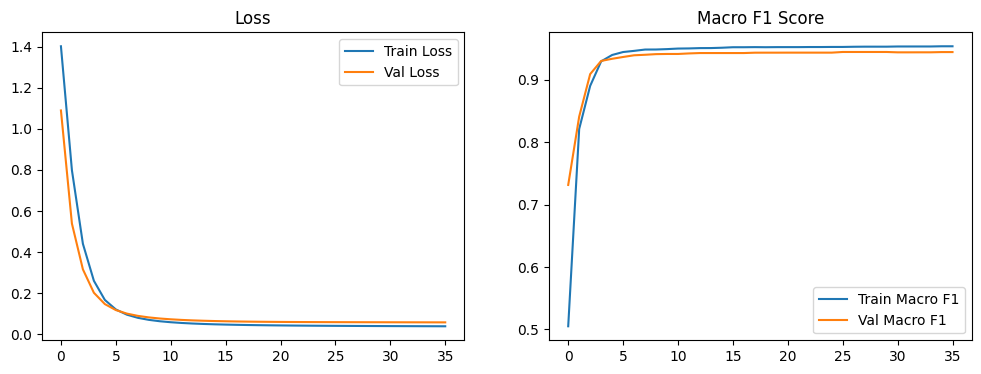

In [441]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history["train_score"], label="Train Macro F1")
plt.plot(history["val_score"], label="Val Macro F1")
plt.legend(); plt.title("Macro F1 Score")
plt.show()

PRC кривая (PRC важнее ROC при дисбалансе):

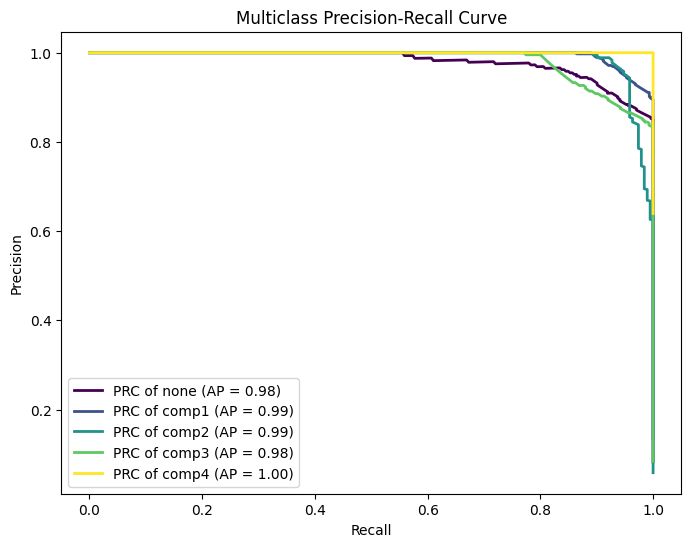

In [442]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Преобразуем y_true в one-hot
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_val_clf_t, classes=np.arange(n_classes))

# Average Precision для каждого класса
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_true_bin[:, i], y_score[:, i])

# Усреднённая PRC
precision["macro"], recall["macro"], _ = precision_recall_curve(
    y_true_bin.ravel(), y_score.ravel()
)
average_precision["macro"] = average_precision_score(y_true_bin, y_score, average="macro")

# График
plt.figure(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, n_classes))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'PRC of {target_names[i]} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multiclass Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

Feature Importance для нейросетей (LSTM, GRU, DLinear, Transformer):

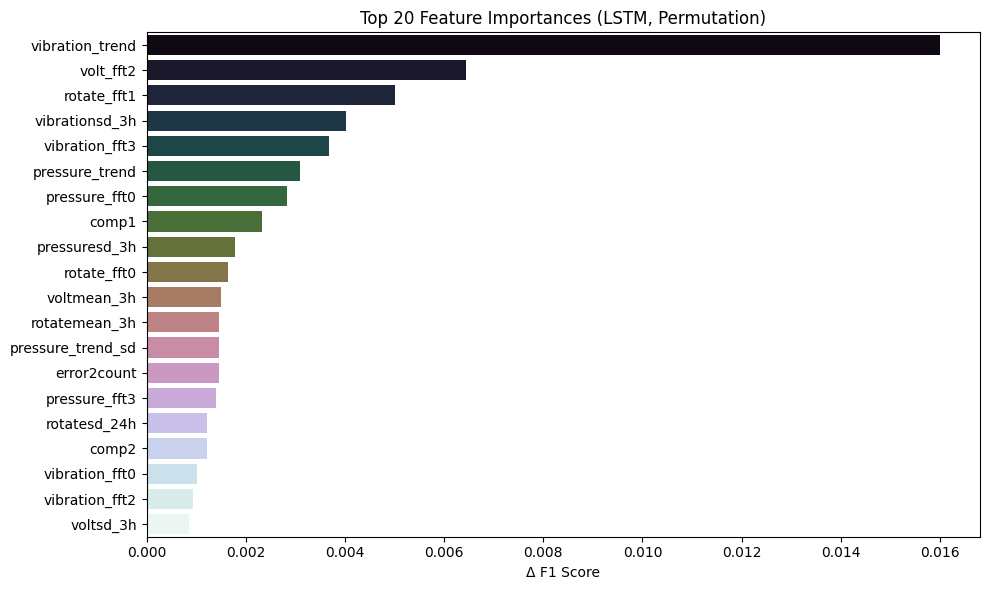

In [443]:
from sklearn.inspection import permutation_importance

def get_permutation_importance_pytorch(model, X_val, y_val, feature_names, task="classification"):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        output = model(X_tensor)
        if task == "classification":
            y_pred_proba = torch.softmax(output, dim=1)[:, 1].cpu().numpy() 
            # Или для мультикласса: используем F1 как метрику
            baseline_score = f1_score(y_val, output.argmax(dim=1).cpu().numpy(), average='macro')
        else:
            y_pred_proba = output.cpu().numpy()
            baseline_score = mean_squared_error(y_val, y_pred_proba)

    # Перестановка
    importances = []
    for i in range(X_val.shape[1]):
        X_perm = X_val.copy()
        np.random.shuffle(X_perm[:, i])
        with torch.no_grad():
            X_tensor_perm = torch.tensor(X_perm, dtype=torch.float32).to(device)
            output_perm = model(X_tensor_perm)
            if task == "classification":
                score = f1_score(y_val, output_perm.argmax(dim=1).cpu().numpy(), average='macro')
            else:
                score = mean_squared_error(y_val, output_perm.cpu().numpy())
        # Для регрессии
        importance = abs(baseline_score - score)
        importances.append(importance)

    return np.array(importances)

# Применение для LSTM
perm_importance_lstm = get_permutation_importance_pytorch(
    lstm_model, X_val, y_val, feature_cols, task="classification"
)

# Визуализация
indices = perm_importance_lstm.argsort()[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=perm_importance_lstm[indices[:20]], y=np.array(feature_cols)[indices[:20]], palette="cubehelix")
plt.title("Top 20 Feature Importances (LSTM, Permutation)")
plt.xlabel("Δ F1 Score")
plt.tight_layout()
plt.show()

In [444]:
# GRUModel
gru_model = GRUModel(input_size, hidden_size=32,  dropout=0.6, task="classification").to(device)

# Обучение
y_score, history = Evaluate(gru_model, train_loader_clf, val_loader_clf, y_train=y_train_clf_t, task="classification", epochs=200)  # (N, 5)

# Для каждого класса настраиваем свой порог
best_thresholds = [0.5]  
for class_id in [1, 2, 3, 4]:
    # Оптимизация под F2-score (recall-ориентированный)
    f2_scores = [
        fbeta_score(
            (y_val == class_id).astype(int),
            (y_score[:, class_id] > t).astype(int),
            beta=2, zero_division=0
        )
        for t in np.linspace(0.1, 0.9, 100)
    ]
    best_t = np.linspace(0.1, 0.9, 100)[np.argmax(f2_scores)]
    best_thresholds.append(best_t)

# Предсказание
adjusted_scores = y_score / np.array(best_thresholds)
y_pred = np.argmax(adjusted_scores, axis=1)

Train 1/200: 100%|██████████| 103/103 [00:00<00:00, 1427.20it/s]


[Train] Epoch: 01. Loss: 1.3853. F1: 45.89%
[Val] Epoch: 01. Loss: 0.9160. F1: 85.38%


Train 2/200: 100%|██████████| 103/103 [00:00<00:00, 1547.45it/s]


[Train] Epoch: 02. Loss: 0.6495. F1: 88.08%
[Val] Epoch: 02. Loss: 0.4049. F1: 89.94%


Train 3/200: 100%|██████████| 103/103 [00:00<00:00, 1540.51it/s]


[Train] Epoch: 03. Loss: 0.3278. F1: 91.66%
[Val] Epoch: 03. Loss: 0.2304. F1: 92.12%


Train 4/200: 100%|██████████| 103/103 [00:00<00:00, 1538.30it/s]


[Train] Epoch: 04. Loss: 0.1933. F1: 93.33%
[Val] Epoch: 04. Loss: 0.1570. F1: 93.07%


Train 5/200: 100%|██████████| 103/103 [00:00<00:00, 1532.10it/s]


[Train] Epoch: 05. Loss: 0.1333. F1: 94.11%
[Val] Epoch: 05. Loss: 0.1229. F1: 93.43%


Train 6/200: 100%|██████████| 103/103 [00:00<00:00, 1555.19it/s]


[Train] Epoch: 06. Loss: 0.1028. F1: 94.42%
[Val] Epoch: 06. Loss: 0.1045. F1: 93.78%


Train 7/200: 100%|██████████| 103/103 [00:00<00:00, 1556.41it/s]


[Train] Epoch: 07. Loss: 0.0850. F1: 94.61%
[Val] Epoch: 07. Loss: 0.0936. F1: 93.91%


Train 8/200: 100%|██████████| 103/103 [00:00<00:00, 1551.62it/s]


[Train] Epoch: 08. Loss: 0.0737. F1: 94.69%
[Val] Epoch: 08. Loss: 0.0866. F1: 93.97%


Train 9/200: 100%|██████████| 103/103 [00:00<00:00, 1561.35it/s]


[Train] Epoch: 09. Loss: 0.0661. F1: 94.88%
[Val] Epoch: 09. Loss: 0.0820. F1: 94.12%


Train 10/200: 100%|██████████| 103/103 [00:00<00:00, 1555.61it/s]


[Train] Epoch: 10. Loss: 0.0607. F1: 94.89%
[Val] Epoch: 10. Loss: 0.0788. F1: 94.20%


Train 11/200: 100%|██████████| 103/103 [00:00<00:00, 1061.49it/s]


[Train] Epoch: 11. Loss: 0.0567. F1: 94.97%
[Val] Epoch: 11. Loss: 0.0765. F1: 94.26%


Train 12/200: 100%|██████████| 103/103 [00:00<00:00, 1543.84it/s]


[Train] Epoch: 12. Loss: 0.0537. F1: 95.03%
[Val] Epoch: 12. Loss: 0.0747. F1: 94.31%


Train 13/200: 100%|██████████| 103/103 [00:00<00:00, 1547.48it/s]


[Train] Epoch: 13. Loss: 0.0513. F1: 95.04%
[Val] Epoch: 13. Loss: 0.0733. F1: 94.31%


Train 14/200: 100%|██████████| 103/103 [00:00<00:00, 1537.54it/s]


[Train] Epoch: 14. Loss: 0.0494. F1: 95.11%
[Val] Epoch: 14. Loss: 0.0722. F1: 94.31%


Train 15/200: 100%|██████████| 103/103 [00:00<00:00, 1546.69it/s]


[Train] Epoch: 15. Loss: 0.0478. F1: 95.13%
[Val] Epoch: 15. Loss: 0.0713. F1: 94.31%


Train 16/200: 100%|██████████| 103/103 [00:00<00:00, 1558.03it/s]


[Train] Epoch: 16. Loss: 0.0464. F1: 95.20%
[Val] Epoch: 16. Loss: 0.0706. F1: 94.31%


Train 17/200: 100%|██████████| 103/103 [00:00<00:00, 1554.35it/s]


[Train] Epoch: 17. Loss: 0.0453. F1: 95.23%
[Val] Epoch: 17. Loss: 0.0699. F1: 94.31%


Train 18/200: 100%|██████████| 103/103 [00:00<00:00, 1559.47it/s]


[Train] Epoch: 18. Loss: 0.0443. F1: 95.23%
[Val] Epoch: 18. Loss: 0.0693. F1: 94.31%


Train 19/200: 100%|██████████| 103/103 [00:00<00:00, 1534.93it/s]


[Train] Epoch: 19. Loss: 0.0435. F1: 95.24%
[Val] Epoch: 19. Loss: 0.0688. F1: 94.31%


Train 20/200: 100%|██████████| 103/103 [00:00<00:00, 1547.10it/s]


[Train] Epoch: 20. Loss: 0.0427. F1: 95.27%
[Val] Epoch: 20. Loss: 0.0684. F1: 94.31%


Train 21/200: 100%|██████████| 103/103 [00:00<00:00, 1527.44it/s]


[Train] Epoch: 21. Loss: 0.0420. F1: 95.30%
[Val] Epoch: 21. Loss: 0.0680. F1: 94.18%


Train 22/200: 100%|██████████| 103/103 [00:00<00:00, 1541.06it/s]


[Train] Epoch: 22. Loss: 0.0414. F1: 95.30%
[Val] Epoch: 22. Loss: 0.0677. F1: 94.23%
Early stopping на эпохе 22


In [445]:
print("GRU (Multiclass Classification):")
print(classification_report(
    y_val_clf_t, 
    y_pred, 
    labels=labels,
    target_names=target_names, 
    zero_division=0
))

# Macro F1-score
macro_f1 = f1_score(y_val_clf_t, y_pred, average="macro")
print("Macro F1-score:", macro_f1)

GRU (Multiclass Classification):
              precision    recall  f1-score   support

        none       0.92      0.90      0.91       272
       comp1       0.96      0.93      0.95       443
       comp2       0.96      0.93      0.95       192
       comp3       0.87      0.95      0.91       275
       comp4       1.00      1.00      1.00      2099

    accuracy                           0.97      3281
   macro avg       0.94      0.94      0.94      3281
weighted avg       0.97      0.97      0.97      3281

Macro F1-score: 0.9421094494616595


In [446]:
# # Feature Importance для GRU
# perm_importance_gru = get_permutation_importance_pytorch(
#     gru_model, X_val, y_val, feature_cols, task="classification"
# )

# # Визуализация
# indices = perm_importance_gru.argsort()[::-1]
# plt.figure(figsize=(10, 6))
# sns.barplot(x=perm_importance_gru[indices[:20]], y=np.array(feature_cols)[indices[:20]], palette="cubehelix")
# plt.title("Top 20 Feature Importances (GRU, Permutation)")
# plt.xlabel("Δ F1 Score")
# plt.tight_layout()
# plt.show()

8.2 DLinear с регуляризацией (нейросеть)

In [447]:
# DLinear с регуляризацией
dlinear_model = DLinear(
    input_size=input_size,
    task="classification",
    n_classes=5,
    dropout=0.6
).to(device)

# Обучение
y_score, history = Evaluate(dlinear_model, train_loader_clf, val_loader_clf, y_train=y_train_clf_t, task="classification", epochs=200)  # (N, 5)

# Для каждого класса настраиваем свой порог
best_thresholds = [0.5]  
for class_id in [1, 2, 3, 4]:
    # Оптимизация под F2-score (recall-ориентированный)
    f2_scores = [
        fbeta_score(
            (y_val == class_id).astype(int),
            (y_score[:, class_id] > t).astype(int),
            beta=2, zero_division=0
        )
        for t in np.linspace(0.1, 0.9, 100)
    ]
    best_t = np.linspace(0.1, 0.9, 100)[np.argmax(f2_scores)]
    best_thresholds.append(best_t)

# Предсказание
adjusted_scores = y_score / np.array(best_thresholds)
y_pred = np.argmax(adjusted_scores, axis=1)

Train 1/200: 100%|██████████| 103/103 [00:00<00:00, 2099.13it/s]


[Train] Epoch: 01. Loss: 1.4797. F1: 32.12%
[Val] Epoch: 01. Loss: 0.8822. F1: 62.27%


Train 2/200: 100%|██████████| 103/103 [00:00<00:00, 2148.17it/s]


[Train] Epoch: 02. Loss: 0.9305. F1: 56.85%
[Val] Epoch: 02. Loss: 0.5980. F1: 88.95%


Train 3/200: 100%|██████████| 103/103 [00:00<00:00, 2116.11it/s]


[Train] Epoch: 03. Loss: 0.7254. F1: 71.92%
[Val] Epoch: 03. Loss: 0.4656. F1: 91.13%


Train 4/200: 100%|██████████| 103/103 [00:00<00:00, 2149.54it/s]


[Train] Epoch: 04. Loss: 0.6628. F1: 73.64%
[Val] Epoch: 04. Loss: 0.3940. F1: 92.20%


Train 5/200: 100%|██████████| 103/103 [00:00<00:00, 2156.39it/s]


[Train] Epoch: 05. Loss: 0.6102. F1: 75.16%
[Val] Epoch: 05. Loss: 0.3467. F1: 92.51%


Train 6/200: 100%|██████████| 103/103 [00:00<00:00, 1379.63it/s]


[Train] Epoch: 06. Loss: 0.5819. F1: 75.02%
[Val] Epoch: 06. Loss: 0.3108. F1: 92.79%


Train 7/200: 100%|██████████| 103/103 [00:00<00:00, 2164.50it/s]


[Train] Epoch: 07. Loss: 0.5519. F1: 75.51%
[Val] Epoch: 07. Loss: 0.2845. F1: 93.17%


Train 8/200: 100%|██████████| 103/103 [00:00<00:00, 2168.73it/s]


[Train] Epoch: 08. Loss: 0.5426. F1: 75.74%
[Val] Epoch: 08. Loss: 0.2647. F1: 93.29%


Train 9/200: 100%|██████████| 103/103 [00:00<00:00, 2147.13it/s]


[Train] Epoch: 09. Loss: 0.5323. F1: 75.31%
[Val] Epoch: 09. Loss: 0.2472. F1: 93.37%


Train 10/200: 100%|██████████| 103/103 [00:00<00:00, 2145.84it/s]


[Train] Epoch: 10. Loss: 0.5247. F1: 74.94%
[Val] Epoch: 10. Loss: 0.2352. F1: 93.38%


Train 11/200: 100%|██████████| 103/103 [00:00<00:00, 2163.14it/s]


[Train] Epoch: 11. Loss: 0.5080. F1: 75.74%
[Val] Epoch: 11. Loss: 0.2224. F1: 93.50%


Train 12/200: 100%|██████████| 103/103 [00:00<00:00, 2161.69it/s]


[Train] Epoch: 12. Loss: 0.5038. F1: 76.14%
[Val] Epoch: 12. Loss: 0.2119. F1: 93.54%


Train 13/200: 100%|██████████| 103/103 [00:00<00:00, 2158.03it/s]


[Train] Epoch: 13. Loss: 0.5012. F1: 75.46%
[Val] Epoch: 13. Loss: 0.2046. F1: 93.85%


Train 14/200: 100%|██████████| 103/103 [00:00<00:00, 2160.60it/s]


[Train] Epoch: 14. Loss: 0.5004. F1: 75.20%
[Val] Epoch: 14. Loss: 0.1977. F1: 93.90%


Train 15/200: 100%|██████████| 103/103 [00:00<00:00, 2175.44it/s]


[Train] Epoch: 15. Loss: 0.4798. F1: 76.56%
[Val] Epoch: 15. Loss: 0.1887. F1: 93.91%


Train 16/200: 100%|██████████| 103/103 [00:00<00:00, 2173.64it/s]


[Train] Epoch: 16. Loss: 0.4871. F1: 75.88%
[Val] Epoch: 16. Loss: 0.1832. F1: 94.08%


Train 17/200: 100%|██████████| 103/103 [00:00<00:00, 2171.85it/s]


[Train] Epoch: 17. Loss: 0.4792. F1: 75.80%
[Val] Epoch: 17. Loss: 0.1754. F1: 93.95%


Train 18/200: 100%|██████████| 103/103 [00:00<00:00, 2173.83it/s]


[Train] Epoch: 18. Loss: 0.4798. F1: 75.97%
[Val] Epoch: 18. Loss: 0.1739. F1: 94.04%


Train 19/200: 100%|██████████| 103/103 [00:00<00:00, 2168.23it/s]


[Train] Epoch: 19. Loss: 0.4809. F1: 75.69%
[Val] Epoch: 19. Loss: 0.1698. F1: 94.01%


Train 20/200: 100%|██████████| 103/103 [00:00<00:00, 2174.37it/s]


[Train] Epoch: 20. Loss: 0.4798. F1: 74.96%
[Val] Epoch: 20. Loss: 0.1661. F1: 93.98%


Train 21/200: 100%|██████████| 103/103 [00:00<00:00, 2162.78it/s]


[Train] Epoch: 21. Loss: 0.4881. F1: 74.81%
[Val] Epoch: 21. Loss: 0.1627. F1: 93.92%


Train 22/200: 100%|██████████| 103/103 [00:00<00:00, 2168.15it/s]


[Train] Epoch: 22. Loss: 0.4675. F1: 75.91%
[Val] Epoch: 22. Loss: 0.1575. F1: 94.12%


Train 23/200: 100%|██████████| 103/103 [00:00<00:00, 2170.07it/s]


[Train] Epoch: 23. Loss: 0.4695. F1: 75.97%
[Val] Epoch: 23. Loss: 0.1551. F1: 93.87%


Train 24/200: 100%|██████████| 103/103 [00:00<00:00, 2173.53it/s]


[Train] Epoch: 24. Loss: 0.4671. F1: 76.01%
[Val] Epoch: 24. Loss: 0.1504. F1: 94.07%


Train 25/200: 100%|██████████| 103/103 [00:00<00:00, 2162.19it/s]


[Train] Epoch: 25. Loss: 0.4710. F1: 75.55%
[Val] Epoch: 25. Loss: 0.1492. F1: 94.00%


Train 26/200: 100%|██████████| 103/103 [00:00<00:00, 2182.01it/s]


[Train] Epoch: 26. Loss: 0.4639. F1: 75.88%
[Val] Epoch: 26. Loss: 0.1465. F1: 93.97%


Train 27/200: 100%|██████████| 103/103 [00:00<00:00, 2168.15it/s]


[Train] Epoch: 27. Loss: 0.4730. F1: 75.38%
[Val] Epoch: 27. Loss: 0.1437. F1: 94.16%


Train 28/200: 100%|██████████| 103/103 [00:00<00:00, 2161.95it/s]


[Train] Epoch: 28. Loss: 0.4789. F1: 75.08%
[Val] Epoch: 28. Loss: 0.1431. F1: 94.08%


Train 29/200: 100%|██████████| 103/103 [00:00<00:00, 2167.00it/s]


[Train] Epoch: 29. Loss: 0.4600. F1: 76.22%
[Val] Epoch: 29. Loss: 0.1401. F1: 93.97%


Train 30/200: 100%|██████████| 103/103 [00:00<00:00, 2138.61it/s]


[Train] Epoch: 30. Loss: 0.4668. F1: 75.22%
[Val] Epoch: 30. Loss: 0.1361. F1: 94.16%


Train 31/200: 100%|██████████| 103/103 [00:00<00:00, 2155.00it/s]


[Train] Epoch: 31. Loss: 0.4600. F1: 76.06%
[Val] Epoch: 31. Loss: 0.1332. F1: 94.16%


Train 32/200: 100%|██████████| 103/103 [00:00<00:00, 2159.01it/s]


[Train] Epoch: 32. Loss: 0.4663. F1: 75.38%
[Val] Epoch: 32. Loss: 0.1325. F1: 94.15%


Train 33/200: 100%|██████████| 103/103 [00:00<00:00, 2165.23it/s]


[Train] Epoch: 33. Loss: 0.4644. F1: 75.69%
[Val] Epoch: 33. Loss: 0.1302. F1: 94.00%


Train 34/200: 100%|██████████| 103/103 [00:00<00:00, 1343.75it/s]


[Train] Epoch: 34. Loss: 0.4721. F1: 74.59%
[Val] Epoch: 34. Loss: 0.1306. F1: 94.09%


Train 35/200: 100%|██████████| 103/103 [00:00<00:00, 2167.70it/s]


[Train] Epoch: 35. Loss: 0.4659. F1: 75.27%
[Val] Epoch: 35. Loss: 0.1301. F1: 94.02%


Train 36/200: 100%|██████████| 103/103 [00:00<00:00, 2151.78it/s]


[Train] Epoch: 36. Loss: 0.4709. F1: 75.38%
[Val] Epoch: 36. Loss: 0.1293. F1: 94.02%


Train 37/200: 100%|██████████| 103/103 [00:00<00:00, 2166.33it/s]


[Train] Epoch: 37. Loss: 0.4737. F1: 74.81%
[Val] Epoch: 37. Loss: 0.1292. F1: 94.04%


Train 38/200: 100%|██████████| 103/103 [00:00<00:00, 2171.62it/s]


[Train] Epoch: 38. Loss: 0.4694. F1: 75.05%
[Val] Epoch: 38. Loss: 0.1268. F1: 94.19%


Train 39/200: 100%|██████████| 103/103 [00:00<00:00, 2170.02it/s]


[Train] Epoch: 39. Loss: 0.4630. F1: 75.48%
[Val] Epoch: 39. Loss: 0.1252. F1: 94.27%


Train 40/200: 100%|██████████| 103/103 [00:00<00:00, 2166.14it/s]


[Train] Epoch: 40. Loss: 0.4642. F1: 74.74%
[Val] Epoch: 40. Loss: 0.1247. F1: 94.13%


Train 41/200: 100%|██████████| 103/103 [00:00<00:00, 2169.21it/s]


[Train] Epoch: 41. Loss: 0.4629. F1: 75.39%
[Val] Epoch: 41. Loss: 0.1237. F1: 94.18%


Train 42/200: 100%|██████████| 103/103 [00:00<00:00, 2175.66it/s]


[Train] Epoch: 42. Loss: 0.4609. F1: 75.57%
[Val] Epoch: 42. Loss: 0.1234. F1: 94.19%


Train 43/200: 100%|██████████| 103/103 [00:00<00:00, 2161.32it/s]


[Train] Epoch: 43. Loss: 0.4759. F1: 75.17%
[Val] Epoch: 43. Loss: 0.1222. F1: 94.12%


Train 44/200: 100%|██████████| 103/103 [00:00<00:00, 2157.88it/s]


[Train] Epoch: 44. Loss: 0.4742. F1: 74.96%
[Val] Epoch: 44. Loss: 0.1209. F1: 94.19%


Train 45/200: 100%|██████████| 103/103 [00:00<00:00, 2169.79it/s]


[Train] Epoch: 45. Loss: 0.4700. F1: 74.97%
[Val] Epoch: 45. Loss: 0.1231. F1: 94.12%


Train 46/200: 100%|██████████| 103/103 [00:00<00:00, 2168.83it/s]


[Train] Epoch: 46. Loss: 0.4712. F1: 75.17%
[Val] Epoch: 46. Loss: 0.1223. F1: 94.13%


Train 47/200: 100%|██████████| 103/103 [00:00<00:00, 2168.23it/s]


[Train] Epoch: 47. Loss: 0.4649. F1: 74.67%
[Val] Epoch: 47. Loss: 0.1205. F1: 94.08%


Train 48/200: 100%|██████████| 103/103 [00:00<00:00, 2165.64it/s]


[Train] Epoch: 48. Loss: 0.4717. F1: 75.47%
[Val] Epoch: 48. Loss: 0.1205. F1: 94.20%


Train 49/200: 100%|██████████| 103/103 [00:00<00:00, 2161.09it/s]


[Train] Epoch: 49. Loss: 0.4670. F1: 74.85%
[Val] Epoch: 49. Loss: 0.1191. F1: 94.18%
Early stopping на эпохе 49


In [448]:
print("DLinear (Multiclass Classification):")
print(classification_report(
    y_val_clf_t, 
    y_pred, 
    labels=labels,
    target_names=target_names, 
    zero_division=0
))

# Macro F1-score
macro_f1 = f1_score(y_val_clf_t, y_pred, average="macro")
print("Macro F1-score:", macro_f1)

DLinear (Multiclass Classification):
              precision    recall  f1-score   support

        none       0.95      0.86      0.90       272
       comp1       0.95      0.94      0.94       443
       comp2       0.95      0.94      0.94       192
       comp3       0.87      0.96      0.91       275
       comp4       1.00      1.00      1.00      2099

    accuracy                           0.97      3281
   macro avg       0.94      0.94      0.94      3281
weighted avg       0.97      0.97      0.97      3281

Macro F1-score: 0.9396559245816647


In [449]:
# # Feature Importance для DLinear
# perm_importance_dlinear = get_permutation_importance_pytorch(
#     dlinear_model, X_val, y_val, feature_cols, task="classification"
# )

# # Визуализация
# indices = perm_importance_dlinear.argsort()[::-1]
# plt.figure(figsize=(10, 6))
# sns.barplot(x=perm_importance_dlinear[indices[:20]], y=np.array(feature_cols)[indices[:20]], palette="cubehelix")
# plt.title("Top 20 Feature Importances (DLinear, Permutation)")
# plt.xlabel("Δ F1 Score")
# plt.tight_layout()
# plt.show()

8.3 Transformer с регуляризацией (нейросеть)

In [450]:
# Transformer с регуляризацией
transformer_model = TransformerModel(
    input_size=input_size,
    hidden_size=16,
    task="classification",
    n_classes=5,
    dropout=0.6
).to(device)

# Обучение
y_score, history = Evaluate(transformer_model, train_loader_clf, val_loader_clf, y_train=y_train_clf_t, task="classification", epochs=200)  # (N, 5)

# Для каждого класса настраиваем свой порог
best_thresholds = [0.5]  
for class_id in [1, 2, 3, 4]:
    # Оптимизация под F2-score (recall-ориентированный)
    f2_scores = [
        fbeta_score(
            (y_val == class_id).astype(int),
            (y_score[:, class_id] > t).astype(int),
            beta=2, zero_division=0
        )
        for t in np.linspace(0.1, 0.9, 100)
    ]
    best_t = np.linspace(0.1, 0.9, 100)[np.argmax(f2_scores)]
    best_thresholds.append(best_t)

# Предсказание
adjusted_scores = y_score / np.array(best_thresholds)
y_pred = np.argmax(adjusted_scores, axis=1)

Train 1/200: 100%|██████████| 103/103 [00:00<00:00, 787.79it/s]


[Train] Epoch: 01. Loss: 1.2145. F1: 38.45%
[Val] Epoch: 01. Loss: 0.6772. F1: 39.78%


Train 2/200: 100%|██████████| 103/103 [00:00<00:00, 876.48it/s]


[Train] Epoch: 02. Loss: 0.7188. F1: 58.27%
[Val] Epoch: 02. Loss: 0.2746. F1: 91.61%


Train 3/200: 100%|██████████| 103/103 [00:00<00:00, 875.28it/s]


[Train] Epoch: 03. Loss: 0.4109. F1: 78.82%
[Val] Epoch: 03. Loss: 0.1607. F1: 93.67%


Train 4/200: 100%|██████████| 103/103 [00:00<00:00, 878.07it/s]


[Train] Epoch: 04. Loss: 0.2925. F1: 85.95%
[Val] Epoch: 04. Loss: 0.1112. F1: 94.01%


Train 5/200: 100%|██████████| 103/103 [00:00<00:00, 698.41it/s]


[Train] Epoch: 05. Loss: 0.2234. F1: 88.62%
[Val] Epoch: 05. Loss: 0.0852. F1: 94.15%


Train 6/200: 100%|██████████| 103/103 [00:00<00:00, 872.96it/s]


[Train] Epoch: 06. Loss: 0.1861. F1: 90.22%
[Val] Epoch: 06. Loss: 0.0734. F1: 94.07%


Train 7/200: 100%|██████████| 103/103 [00:00<00:00, 880.89it/s]


[Train] Epoch: 07. Loss: 0.1583. F1: 91.25%
[Val] Epoch: 07. Loss: 0.0642. F1: 94.10%


Train 8/200: 100%|██████████| 103/103 [00:00<00:00, 869.12it/s]


[Train] Epoch: 08. Loss: 0.1453. F1: 91.33%
[Val] Epoch: 08. Loss: 0.0606. F1: 94.11%


Train 9/200: 100%|██████████| 103/103 [00:00<00:00, 879.72it/s]


[Train] Epoch: 09. Loss: 0.1315. F1: 91.91%
[Val] Epoch: 09. Loss: 0.0582. F1: 94.35%


Train 10/200: 100%|██████████| 103/103 [00:00<00:00, 883.03it/s]


[Train] Epoch: 10. Loss: 0.1249. F1: 91.95%
[Val] Epoch: 10. Loss: 0.0576. F1: 94.10%


Train 11/200: 100%|██████████| 103/103 [00:00<00:00, 884.36it/s]


[Train] Epoch: 11. Loss: 0.1142. F1: 92.18%
[Val] Epoch: 11. Loss: 0.0563. F1: 94.15%


Train 12/200: 100%|██████████| 103/103 [00:00<00:00, 882.41it/s]


[Train] Epoch: 12. Loss: 0.1145. F1: 92.14%
[Val] Epoch: 12. Loss: 0.0556. F1: 94.23%


Train 13/200: 100%|██████████| 103/103 [00:00<00:00, 880.03it/s]


[Train] Epoch: 13. Loss: 0.1094. F1: 92.39%
[Val] Epoch: 13. Loss: 0.0555. F1: 94.17%


Train 14/200: 100%|██████████| 103/103 [00:00<00:00, 881.82it/s]


[Train] Epoch: 14. Loss: 0.1062. F1: 92.99%
[Val] Epoch: 14. Loss: 0.0563. F1: 94.10%


Train 15/200: 100%|██████████| 103/103 [00:00<00:00, 881.17it/s]


[Train] Epoch: 15. Loss: 0.0997. F1: 92.87%
[Val] Epoch: 15. Loss: 0.0559. F1: 94.04%


Train 16/200: 100%|██████████| 103/103 [00:00<00:00, 886.53it/s]


[Train] Epoch: 16. Loss: 0.0989. F1: 92.96%
[Val] Epoch: 16. Loss: 0.0580. F1: 94.27%


Train 17/200: 100%|██████████| 103/103 [00:00<00:00, 886.21it/s]


[Train] Epoch: 17. Loss: 0.0978. F1: 92.56%
[Val] Epoch: 17. Loss: 0.0561. F1: 94.35%


Train 18/200: 100%|██████████| 103/103 [00:00<00:00, 879.45it/s]


[Train] Epoch: 18. Loss: 0.0921. F1: 92.99%
[Val] Epoch: 18. Loss: 0.0544. F1: 94.35%


Train 19/200: 100%|██████████| 103/103 [00:00<00:00, 880.25it/s]


[Train] Epoch: 19. Loss: 0.0927. F1: 93.13%
[Val] Epoch: 19. Loss: 0.0575. F1: 94.36%


Train 20/200: 100%|██████████| 103/103 [00:00<00:00, 881.46it/s]


[Train] Epoch: 20. Loss: 0.0905. F1: 92.95%
[Val] Epoch: 20. Loss: 0.0552. F1: 94.29%


Train 21/200: 100%|██████████| 103/103 [00:00<00:00, 882.41it/s]


[Train] Epoch: 21. Loss: 0.0896. F1: 93.06%
[Val] Epoch: 21. Loss: 0.0565. F1: 94.24%


Train 22/200: 100%|██████████| 103/103 [00:00<00:00, 874.53it/s]


[Train] Epoch: 22. Loss: 0.0911. F1: 93.09%
[Val] Epoch: 22. Loss: 0.0563. F1: 94.28%


Train 23/200: 100%|██████████| 103/103 [00:00<00:00, 882.96it/s]


[Train] Epoch: 23. Loss: 0.0894. F1: 92.68%
[Val] Epoch: 23. Loss: 0.0563. F1: 94.33%


Train 24/200: 100%|██████████| 103/103 [00:00<00:00, 879.22it/s]


[Train] Epoch: 24. Loss: 0.0892. F1: 92.96%
[Val] Epoch: 24. Loss: 0.0565. F1: 94.25%


Train 25/200: 100%|██████████| 103/103 [00:00<00:00, 882.61it/s]


[Train] Epoch: 25. Loss: 0.0855. F1: 93.16%
[Val] Epoch: 25. Loss: 0.0602. F1: 94.24%


Train 26/200: 100%|██████████| 103/103 [00:00<00:00, 695.18it/s]


[Train] Epoch: 26. Loss: 0.0873. F1: 92.89%
[Val] Epoch: 26. Loss: 0.0568. F1: 94.47%


Train 27/200: 100%|██████████| 103/103 [00:00<00:00, 881.77it/s]


[Train] Epoch: 27. Loss: 0.0885. F1: 92.89%
[Val] Epoch: 27. Loss: 0.0578. F1: 94.29%


Train 28/200: 100%|██████████| 103/103 [00:00<00:00, 885.65it/s]


[Train] Epoch: 28. Loss: 0.0869. F1: 92.90%
[Val] Epoch: 28. Loss: 0.0565. F1: 94.29%


Train 29/200: 100%|██████████| 103/103 [00:00<00:00, 883.85it/s]


[Train] Epoch: 29. Loss: 0.0861. F1: 92.83%
[Val] Epoch: 29. Loss: 0.0570. F1: 94.21%


Train 30/200: 100%|██████████| 103/103 [00:00<00:00, 787.20it/s]


[Train] Epoch: 30. Loss: 0.0848. F1: 92.91%
[Val] Epoch: 30. Loss: 0.0583. F1: 94.29%


Train 31/200: 100%|██████████| 103/103 [00:00<00:00, 884.14it/s]


[Train] Epoch: 31. Loss: 0.0839. F1: 93.09%
[Val] Epoch: 31. Loss: 0.0577. F1: 94.40%


Train 32/200: 100%|██████████| 103/103 [00:00<00:00, 883.36it/s]


[Train] Epoch: 32. Loss: 0.0878. F1: 93.03%
[Val] Epoch: 32. Loss: 0.0601. F1: 94.19%


Train 33/200: 100%|██████████| 103/103 [00:00<00:00, 879.96it/s]


[Train] Epoch: 33. Loss: 0.0834. F1: 93.04%
[Val] Epoch: 33. Loss: 0.0597. F1: 94.34%


Train 34/200: 100%|██████████| 103/103 [00:00<00:00, 883.92it/s]


[Train] Epoch: 34. Loss: 0.0862. F1: 92.97%
[Val] Epoch: 34. Loss: 0.0609. F1: 94.27%


Train 35/200: 100%|██████████| 103/103 [00:00<00:00, 883.76it/s]


[Train] Epoch: 35. Loss: 0.0845. F1: 93.27%
[Val] Epoch: 35. Loss: 0.0595. F1: 94.42%


Train 36/200: 100%|██████████| 103/103 [00:00<00:00, 885.53it/s]


[Train] Epoch: 36. Loss: 0.0860. F1: 93.14%
[Val] Epoch: 36. Loss: 0.0591. F1: 94.35%
Early stopping на эпохе 36


In [451]:
print("Transformer (Multiclass Classification):")
print(classification_report(
    y_val_clf_t, 
    y_pred, 
    labels=labels,
    target_names=target_names, 
    zero_division=0
))

# Macro F1-score
macro_f1 = f1_score(y_val_clf_t, y_pred, average="macro")
print("Macro F1-score:", macro_f1)

Transformer (Multiclass Classification):
              precision    recall  f1-score   support

        none       0.92      0.90      0.91       272
       comp1       0.97      0.93      0.95       443
       comp2       0.96      0.94      0.95       192
       comp3       0.87      0.95      0.91       275
       comp4       1.00      1.00      1.00      2099

    accuracy                           0.97      3281
   macro avg       0.94      0.94      0.94      3281
weighted avg       0.98      0.97      0.97      3281

Macro F1-score: 0.9430640188333745


In [452]:
# # Feature Importance для Transformer
# perm_importance_transformer = get_permutation_importance_pytorch(
#     transformer_model, X_val, y_val, feature_cols, task="classification"
# )

# # Визуализация
# indices = perm_importance_transformer.argsort()[::-1]
# plt.figure(figsize=(10, 6))
# sns.barplot(
#     x=np.abs(perm_importance_transformer[indices[:20]]), 
#     y=np.array(feature_cols)[indices[:20]],
#     palette="cubehelix"
# )
# plt.title("Top 20 Feature Importances (Transformer, Permutation)")
# plt.xlabel("Δ F1 Score")
# plt.tight_layout()
# plt.show()

8.4 Random Forest с балансировкой классов

In [453]:
# Random Forest с балансировкой
rf_balanced = RandomForestClassifier(
    n_estimators=100,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_balanced.fit(X_train_clf_t, y_train_clf_t)

# Предсказание вероятностей
y_score = rf_balanced.predict_proba(X_val_clf_t)  # (N, 5)

# Оценка
target_names = ["none", "comp1", "comp2", "comp3", "comp4"]
labels = [0, 1, 2, 3, 4]

# Для каждого класса настраиваем свой порог
best_thresholds = [0.5]  
for class_id in [1, 2, 3, 4]:
    # Оптимизация под F2-score (recall-ориентированный)
    f2_scores = [
        fbeta_score(
            (y_val == class_id).astype(int),
            (y_score[:, class_id] > t).astype(int),
            beta=2, zero_division=0
        )
        for t in np.linspace(0.1, 0.9, 100)
    ]
    best_t = np.linspace(0.1, 0.9, 100)[np.argmax(f2_scores)]
    best_thresholds.append(best_t)

# Финальное предсказание
adjusted_scores = y_score / np.array(best_thresholds)
y_pred = np.argmax(adjusted_scores, axis=1)

In [454]:
print("Random Forest (Balanced):")
print(classification_report(y_val_clf_t, y_pred, target_names=target_names))

# Macro F1-score
macro_f1 = f1_score(y_val_clf_t, y_pred, average="macro")
print("Macro F1-score:", macro_f1)

Random Forest (Balanced):
              precision    recall  f1-score   support

        none       1.00      0.82      0.90       272
       comp1       0.92      0.97      0.94       443
       comp2       0.92      0.96      0.94       192
       comp3       0.89      0.92      0.91       275
       comp4       1.00      1.00      1.00      2099

    accuracy                           0.97      3281
   macro avg       0.94      0.94      0.94      3281
weighted avg       0.97      0.97      0.97      3281

Macro F1-score: 0.938176168750011


In [455]:
# # Feature Importance для деревьев
# importances = rf_balanced.feature_importances_
# feature_names = np.array(feature_cols)

# # Сортировка
# indices = importances.argsort()[::-1]

# # Визуализация
# plt.figure(figsize=(10, 6))
# sns.barplot(x=importances[indices[:20]], y=feature_names[indices[:20]], palette="viridis")
# plt.title("Top 20 Feature Importances (Random Forest)")
# plt.xlabel("Importance")
# plt.tight_layout()
# plt.show()

8.5 GradientBoostingClassifier с балансировкой через sample_weight

In [456]:
# Вычисление весов для каждого примера
sample_weights = compute_sample_weight(
    class_weight="balanced",
    y=y_train  
)

# Обучение GradientBoostingClassifier с весами
gbc_balanced = GradientBoostingClassifier(
    n_estimators=100,
    random_state=42,
    learning_rate=0.1,
    max_depth=7
)
gbc_balanced.fit(X_train_clf_t, y_train_clf_t)

# Предсказание вероятностей
y_score = gbc_balanced.predict_proba(X_val_clf_t)  # (N, 5)

# Настройка порогов под F2-score 
best_thresholds = [0.5]  
for class_id in [1, 2, 3, 4]:
    f2_scores = [
        fbeta_score(
            (y_val == class_id).astype(int),
            (y_score[:, class_id] > t).astype(int),
            beta=2,
            zero_division=0
        )
        for t in np.linspace(0.1, 0.9, 100)
    ]
    best_t = np.linspace(0.1, 0.9, 100)[np.argmax(f2_scores)]
    best_thresholds.append(best_t)

# Финальное предсказание
adjusted_scores = y_score / np.array(best_thresholds)
y_pred = np.argmax(adjusted_scores, axis=1)

In [457]:
print("GradientBoosting (Balanced):")
print(classification_report(y_val, y_pred, target_names=target_names, labels=labels, zero_division=0))

macro_f1_gbc = f1_score(y_val, y_pred, average="macro")
print("Macro F1-score:", macro_f1_gbc)

GradientBoosting (Balanced):
              precision    recall  f1-score   support

        none       0.97      0.87      0.92       272
       comp1       0.93      0.94      0.94       443
       comp2       0.94      0.95      0.95       192
       comp3       0.86      0.93      0.90       275
       comp4       1.00      1.00      1.00      2099

    accuracy                           0.97      3281
   macro avg       0.94      0.94      0.94      3281
weighted avg       0.97      0.97      0.97      3281

Macro F1-score: 0.9398981240130839


In [458]:
# # Feature Importance для градиента
# importances = gbc_balanced.feature_importances_
# feature_names = np.array(feature_cols)

# # Сортировка
# indices = importances.argsort()[::-1]

# # Визуализация
# plt.figure(figsize=(10, 6))
# sns.barplot(x=importances[indices[:20]], y=feature_names[indices[:20]], palette="viridis")
# plt.title("Top 20 Feature Importances (Gradient Boosting)")
# plt.xlabel("Importance")
# plt.tight_layout()
# plt.show()

Почему не ARIMA?

ARIMA was tested but showed inferior performance compared to deep learning models due to its linearity and inability to capture multivariate dependencies.

## Шаг 9: Регрессия (RUL)

9.1 LSTM – регрессия (RUL)

In [459]:
# Модель
model = LSTMModel(
    input_size=input_size,
    hidden_size=32,
    dropout=0.3,
    task="regression"
).to(device)

# Обучение
y_pred_rul, history_rul = Evaluate(
    model, 
    train_loader_rul, 
    val_loader_rul, 
    task="regression", 
    epochs=100
)

# Оценка
rmse = np.sqrt(mean_squared_error(y_val_rul, y_pred_rul))
print(f"LSTM RUL RMSE: {rmse:.6f}")

Train 1/100:   0%|          | 0/9 [00:00<?, ?it/s]


AttributeError: 'NoneType' object has no attribute 'size'

9.2 DLinear – регрессия (RUL)

In [ ]:
# Модель
model = DLinear(
    input_size=input_size,
    dropout=0.3,
    task="regression"
).to(device)

# Обучение
y_pred_rul, history_rul = Evaluate(
    model, 
    train_loader_rul, 
    val_loader_rul, 
    task="regression", 
    epochs=100
)

# Убедимся, что y_pred_rul массив предсказаний
y_val_rul_np = y_val_rul_t.cpu().numpy()
y_pred_rul = y_pred_rul.flatten() if y_pred_rul.ndim > 1 else y_pred_rul

# Оценка
rmse = np.sqrt(mean_squared_error(y_val_rul_np, y_pred_rul))
print(f"DLinear RUL RMSE: {rmse:.6f}")

Train 1/100: 100%|██████████| 42/42 [00:00<00:00, 1242.86it/s]


[Train] Epoch: 01. Loss: nan. F1: nan%
[Val] Epoch: 01. Loss: nan. F1: nan%


Train 2/100: 100%|██████████| 42/42 [00:00<00:00, 1830.07it/s]


[Train] Epoch: 02. Loss: nan. F1: nan%
[Val] Epoch: 02. Loss: nan. F1: nan%


Train 3/100: 100%|██████████| 42/42 [00:00<00:00, 2211.44it/s]


[Train] Epoch: 03. Loss: nan. F1: nan%
[Val] Epoch: 03. Loss: nan. F1: nan%


Train 4/100: 100%|██████████| 42/42 [00:00<00:00, 2069.39it/s]


[Train] Epoch: 04. Loss: nan. F1: nan%
[Val] Epoch: 04. Loss: nan. F1: nan%


Train 5/100: 100%|██████████| 42/42 [00:00<00:00, 2159.73it/s]


[Train] Epoch: 05. Loss: nan. F1: nan%
[Val] Epoch: 05. Loss: nan. F1: nan%


Train 6/100: 100%|██████████| 42/42 [00:00<00:00, 2199.04it/s]


[Train] Epoch: 06. Loss: nan. F1: nan%
[Val] Epoch: 06. Loss: nan. F1: nan%


Train 7/100: 100%|██████████| 42/42 [00:00<00:00, 810.26it/s]


[Train] Epoch: 07. Loss: nan. F1: nan%
[Val] Epoch: 07. Loss: nan. F1: nan%


Train 8/100: 100%|██████████| 42/42 [00:00<00:00, 2226.36it/s]


[Train] Epoch: 08. Loss: nan. F1: nan%
[Val] Epoch: 08. Loss: nan. F1: nan%


Train 9/100: 100%|██████████| 42/42 [00:00<00:00, 2185.48it/s]


[Train] Epoch: 09. Loss: nan. F1: nan%
[Val] Epoch: 09. Loss: nan. F1: nan%


Train 10/100: 100%|██████████| 42/42 [00:00<00:00, 2172.79it/s]


[Train] Epoch: 10. Loss: nan. F1: nan%
[Val] Epoch: 10. Loss: nan. F1: nan%
Early stopping на эпохе 10


ValueError: Input contains NaN.